In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval,SqrtStretch,ZScaleInterval,PercentileInterval,ImageNormalize)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch
from itertools import repeat
from matplotlib.colors import LogNorm
import os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.stats import norm
import pickle

In [2]:
def fun_fit(x,a,b,c,d):
    return a*x**3.+b*x**2.+c*x+d

In [3]:
inputdir = '/pbs/throng/lsst/users/mrodrigu/desc/AuxTelComm/notebookccdm_gen3/bouguerlines/2022_09/data/'

In [4]:
file_label = 'run-auxtel-holo-{0}-{1}~{2}-config_DECONVOLUTION_PSF1D.pickle'

In [5]:
outdir = './output_files/'
if os.path.exists(outdir)==False:
    os.mkdir(outdir)

In [6]:
obs_date = '20220628'
filter = 'FELH0600'
disperser = 'holo4_003'

In [7]:
save_txt = True

In [8]:
inputfile = os.path.join(inputdir,file_label.format(obs_date,filter,disperser))

In [9]:
with open(inputfile,'rb') as f:
    spec_dict = pickle.load(f)

In [10]:
#for key in spec_dict.keys():
#    print(spec_dict[key]['number'])

In [11]:
bad_spec_dict = {'20220628':[171,223,250,251,400,425,479,480,538,593,654,655,656,657,683,708],
                 '20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593]}

In [12]:
bad_spec = bad_spec_dict[obs_date]

In [13]:
spec_dict_good = {}
for key in spec_dict.keys():
    if int(spec_dict[key]['number']) not in bad_spec:
        spec_dict_good[key] = spec_dict[key]

In [14]:
ref_obs = 'exposure_2022062800143_postisrccd_spectrum.fits'

In [15]:
lambda_ref = spec_dict_good[ref_obs]['all_lambdas']
flux_ref = spec_dict_good[ref_obs]['all_fluxes']

In [16]:
min_cont = 740
max_cont = 790
min_lin = 750
max_lin = 780

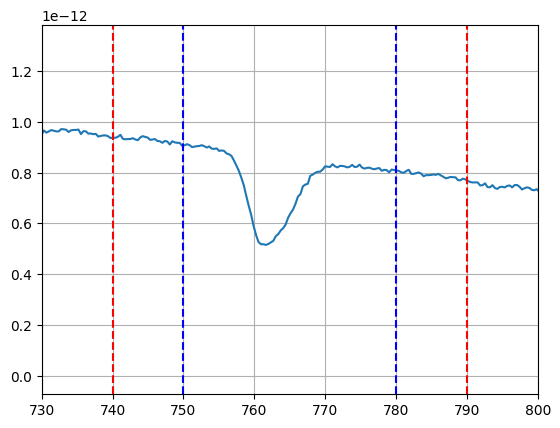

In [17]:
plt.plot(spec_dict_good[ref_obs]['all_lambdas'],spec_dict_good[ref_obs]['all_fluxes'])
plt.xlim(730,800)
plt.axvline(x=min_cont,color='r',ls='--')
plt.axvline(x=max_cont,color='r',ls='--')
plt.axvline(x=min_lin,color='b',ls='--')
plt.axvline(x=max_lin,color='b',ls='--')
plt.grid()

In [18]:
o2_lambda = 762.

In [19]:
def eqw(x,flux,min_cont,max_cont,min_lin,max_lin,central_lambda=None,return_fit=False,make_plot=True,plot_name='test.png'): 
    
    xmask_c = (x>=min_cont)*(x<=max_cont)
    xmask_fit = (x>=min_cont)*(x<=min_lin)+(x<=max_cont)*(x>=max_lin)
    
    
    xline = x[xmask_c]
    fline = flux[xmask_c]
    
    xc1 = x[xmask_fit]
    yc1 = flux[xmask_fit]

    xc2 = x[xmask_fit]
    yc2 = flux[xmask_fit]
    
    xc3 = np.concatenate((xc1,xc2))
    yc3 = np.concatenate((yc1,yc2))
    
    p3,cov3 = curve_fit(fun_fit,xc3,yc3)
        
    linemask = (xline>=min_lin)*(xline<=max_lin)
    xline_model = xline[linemask]
    fline_model = fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3])
    #fline_model = fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4])
    #fline_model = fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7])
    
    def fun_fit_(x):
        return fun_fit(x,p3[0],p3[1],p3[2],p3[3])
    
    norm_array = fun_fit_(xline)
    
    #area_c = np.trapz(fline_model,xline_model)
    area_c = quad(fun_fit_,min_lin,max_lin)[0]
    area_ul = np.trapz(fline[linemask],xline_model)
    
    area_l = area_c-area_ul
    #print(area_c)
    #print(area_ul)
    #print(area_l)
    
    if central_lambda==None:
        xmin_line = xline_model[np.where(fline[linemask]==np.min(fline[linemask]))[0]][0]
        #print(xmin_line)
    else:
        xmin_line = central_lambda
    cont_min = fun_fit(xmin_line,p3[0],p3[1],p3[2],p3[3])
    #cont_min = fun_fit(xmin_line,p3[0],p3[1],p3[2],p3[3],p3[4])[0]
    #cont_min = fun_fit(xmin_line,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7])[0]
    #print(cont_min)
    
    eqw = area_l/cont_min
    #print('EQW = ',eqw)
    
    eqwmask = (xline_model>=xmin_line-eqw/2.)*(xline_model<=xmin_line+eqw/2.)
    continuum = np.ones(len(fline_model[eqwmask]))*cont_min
    #print(continuum)
    #print(xmin_line-eqw/2.,xmin_line+eqw/2.)
    
    #print(len(xline_model))
    #print(len(fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3])))
    #print(len(fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4])))
    #print(len(fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7])))
    #print(len(fline[linemask]))
    
    if make_plot:
        fig=plt.figure(figsize=(10,6))
        plt.plot(xline,fline)
        plt.plot(xline,fun_fit(xline,p3[0],p3[1],p3[2],p3[3]),ls='--',color='orange')
        #plt.plot(xline,fun_fit(xline,p3[0],p3[1],p3[2],p3[3],p3[4]),ls='--',color='orange')
        #plt.plot(xline,fun_fit(xline,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7]),ls='--',color='orange')
        plt.fill_between(xline_model,fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3]),fline[linemask],color='gray',alpha=0.2)
        #plt.fill_between(xline_model,fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4]),fline[linemask],color='gray',alpha=0.2)
        #plt.fill_between(xline_model,fline_model,fline[linemask],color='gray',alpha=0.2)
        plt.fill_between(xline_model[eqwmask],continuum,color='cyan',alpha=0.2)
        #plt.ylim(0.20,0.30)
        #plt.ylim(70000,90000)
        plt.xlabel(r'$\lambda \, [nm]$',fontsize=12)
        plt.ylabel(r'$\gamma \, / \, (s \cdot cm^2 \cdot nm)$',fontsize=12)
        plt.grid()
        '''
        plot_outdir = 'output_plots/eqw_line_fit_{0}/'.format(source_spec)
        if os.path.exists(plot_outdir)==False:
            os.mkdir(plot_outdir)
        plt.savefig(plot_outdir+plot_name) 
        '''
    if return_fit:
        return eqw, p3, xline, fline, fun_fit(xline,p3[0],p3[1],p3[2],p3[3]) #fun_fit(xline,p3[0],p3[1],p3[2],p3[3],p3[4]) #fun_fit(xline,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7])
    else:
        return eqw
    

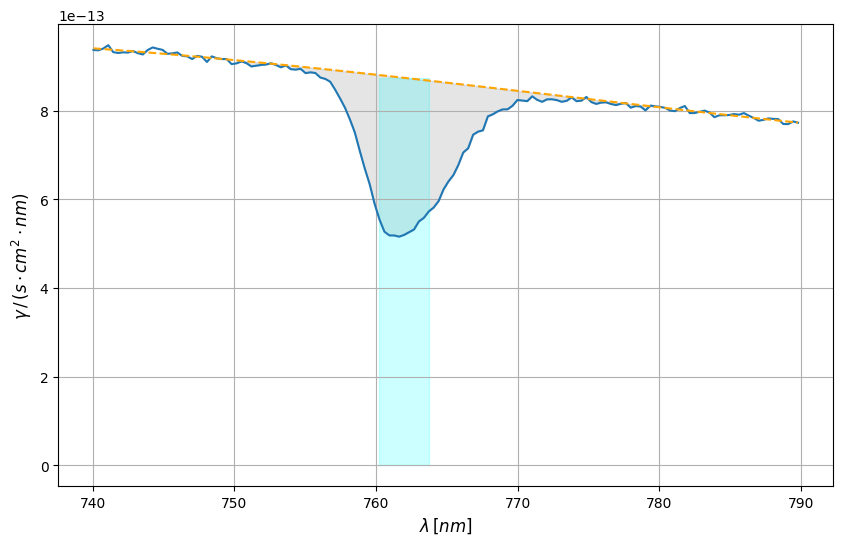

In [20]:
#eqw, params, x, fl = eqw(x_,specdf_ref,xmask_c,xmin_int,xmax_int,xmin_line)
eqw_val = eqw(lambda_ref,flux_ref,min_cont,max_cont,min_lin,max_lin,central_lambda=o2_lambda)

In [21]:
print(eqw_val)

3.5275915376866958


# Iterate over all available images (both with and without flat-fielding) 

In [22]:
airmass = []
pressure = []
eqwidth = []
for spec in spec_dict_good:
    #print(spec)
    airmass_ = spec_dict_good[spec]['airmass']
    pressure_ = spec_dict_good[spec]['pressure']
    
    lambda_ = spec_dict_good[spec]['all_lambdas']
    flux_ = spec_dict_good[spec]['all_fluxes']
    #print(lambda_)
    #print(flux_)
    
    eqw_ = eqw(lambda_,flux_,min_cont,max_cont,min_lin,max_lin,make_plot=False)
    '''
    if eqwdb_<0.:
        print(seqn)
        plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
        eqwdb_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    elif eqwdf_<0.:
        print(seqn)
        plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
        eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    
    plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
    eqw0_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    
    plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
    eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    '''
    airmass.append(airmass_)
    pressure.append(pressure_)
    eqwidth.append(eqw_)
airmass = np.array(airmass)
pressure = np.array(pressure)
eqwidth = np.array(eqwidth)
if save_txt:
    data = np.transpose(np.array([airmass,pressure,eqwidth]))
    np.savetxt('eqw_data_{0}_{1}_{2}.txt'.format(obs_date,filter,disperser),data,header='airmass pressure eqw')

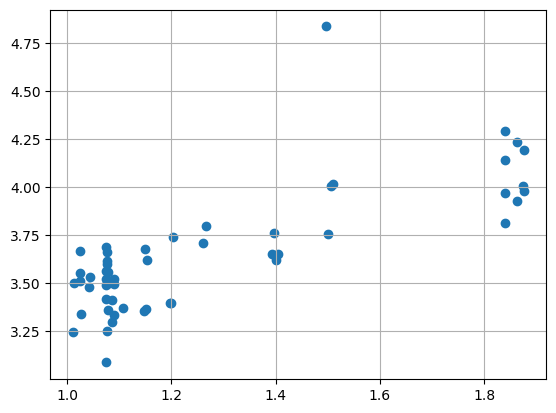

In [23]:
plt.scatter(airmass,eqwidth)
plt.grid()

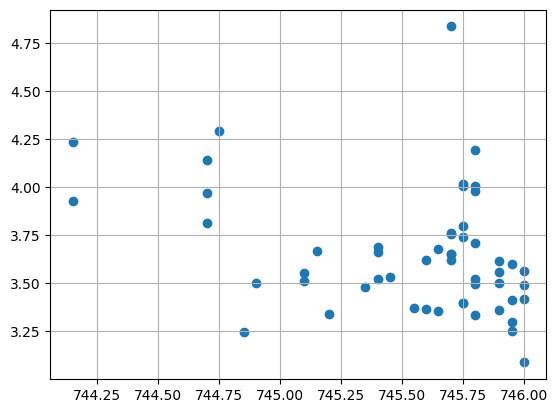

In [24]:
plt.scatter(pressure,eqwidth)
plt.grid()

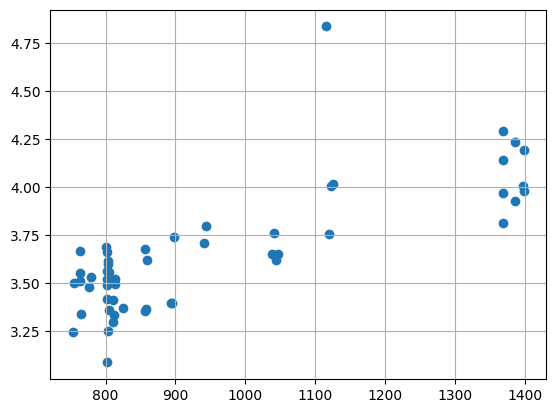

In [25]:
plt.scatter(airmass*pressure,eqwidth)
plt.grid()

# Now with normalisation

In [26]:
def eqw_norm(x,flux,min_cont,max_cont,min_lin,max_lin,central_lambda=None,return_fit=False,make_plot=True,plot_name='test.png'): 
    
    xmask_c = (x>=min_cont)*(x<=max_cont)
    xmask_fit = (x>=min_cont)*(x<=min_lin)+(x<=max_cont)*(x>=max_lin)
    
    
    xline = x[xmask_c]
    fline = flux[xmask_c]
    
    xc1 = x[xmask_fit]
    yc1 = flux[xmask_fit]

    xc2 = x[xmask_fit]
    yc2 = flux[xmask_fit]
    
    xc3 = np.concatenate((xc1,xc2))
    yc3 = np.concatenate((yc1,yc2))

    def fun_fit(x,a,b): # redefine the function as a line just for being able to run the test. A line is expected anyway !
        return a*x+b
    
    p3,cov3 = curve_fit(fun_fit,xc3,yc3)
        
    linemask = (xline>=min_lin)*(xline<=max_lin)
    xline_model = xline[linemask]
    fline_model = fun_fit(xline_model,p3[0],p3[1])#,p3[2],p3[3])
    
    def fun_fit_(x):
        return fun_fit(x,p3[0],p3[1]) #,p3[2],p3[3])
    
    def normed_fit_(x): ## must return 1.
        return fun_fit_(x) / fun_fit_(x)
    
    norm_array = fun_fit_(xline)
    
    #area_c = np.trapz(fline_model,xline_model)
    area_c = quad(normed_fit_,min_lin,max_lin)[0]
    area_ul = np.trapz(fline[linemask]/norm_array[linemask],xline_model)
    
    area_l = area_c-area_ul
    #print(area_c)
    #print(area_ul)
    #print(area_l)
    
    if central_lambda==None:
        xmin_line = xline_model[np.where(fline[linemask]==np.min(fline[linemask]))[0]][0]
        #print(xmin_line)
    else:
        xmin_line = central_lambda
    cont_min = fun_fit(xmin_line,p3[0],p3[1]) #,p3[2],p3[3])
    #print(cont_min)
    
    eqw = area_l #/cont_min
    #print('EQW = ',eqw)
    
    eqwmask = (xline_model>=xmin_line-eqw/2.)*(xline_model<=xmin_line+eqw/2.)
    continuum = np.ones(len(fline_model[eqwmask])) #*cont_min
    #print(continuum)
    #print(xmin_line-eqw/2.,xmin_line+eqw/2.)
    
    #print(len(xline_model))
    #print(len(fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3])))
    #print(len(fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4])))
    #print(len(fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7])))
    #print(len(fline[linemask]))
    
    if make_plot:
        fig=plt.figure(figsize=(10,6))
        plt.plot(xline,fline/norm_array)
        plt.plot(xline,normed_fit_(xline),ls='--',color='orange')
        plt.fill_between(xline_model,normed_fit_(xline_model),fline[linemask]/norm_array[linemask],color='gray',alpha=0.2)
        plt.fill_between(xline_model[eqwmask],continuum,color='cyan',alpha=0.2)
        #plt.ylim(0.20,0.30)
        #plt.ylim(70000,90000)
        plt.xlabel(r'$\lambda \, [nm]$',fontsize=12)
        plt.ylabel(r'$\gamma \, / \, (s \cdot cm^2 \cdot nm)$',fontsize=12)
        plt.grid()
        '''
        plot_outdir = 'output_plots/eqw_line_fit_{0}/'.format(source_spec)
        if os.path.exists(plot_outdir)==False:
            os.mkdir(plot_outdir)
        plt.savefig(plot_outdir+plot_name) 
        '''
    if return_fit:
        return eqw, p3, xline, fline, fun_fit(xline,p3[0],p3[1]) #,p3[2],p3[3]) #fun_fit(xline,p3[0],p3[1],p3[2],p3[3],p3[4]) #fun_fit(xline,p3[0],p3[1],p3[2],p3[3],p3[4],p3[5],p3[6],p3[7])
    else:
        return eqw
    

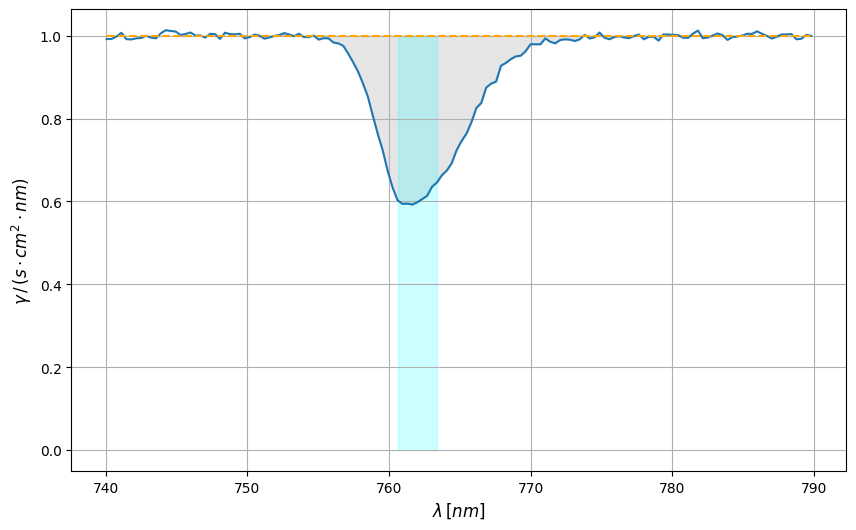

In [27]:
#eqw, params, x, fl = eqw(x_,specdf_ref,xmask_c,xmin_int,xmax_int,xmin_line)
eqw_val = eqw_norm(lambda_ref,flux_ref,min_cont,max_cont,min_lin,max_lin,central_lambda=o2_lambda)

In [28]:
print(eqw_val)

3.4458841628778814


## Iterate

In [29]:
airmass = []
pressure = []
eqwidth = []
for spec in spec_dict_good:
    #print(spec)
    airmass_ = spec_dict_good[spec]['airmass']
    pressure_ = spec_dict_good[spec]['pressure']
    
    lambda_ = spec_dict_good[spec]['all_lambdas']
    flux_ = spec_dict_good[spec]['all_fluxes']
    #print(lambda_)
    #print(flux_)
    
    eqw_ = eqw_norm(lambda_,flux_,min_cont,max_cont,min_lin,max_lin,make_plot=False)
    '''
    if eqwdb_<0.:
        print(seqn)
        plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
        eqwdb_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    elif eqwdf_<0.:
        print(seqn)
        plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
        eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    
    plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
    eqw0_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    
    plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
    eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    '''
    airmass.append(airmass_)
    pressure.append(pressure_)
    eqwidth.append(eqw_)
airmass = np.array(airmass)
pressure = np.array(pressure)
eqwidth = np.array(eqwidth)
if save_txt:
    data = np.transpose(np.array([airmass,pressure,eqwidth]))
    np.savetxt('eqw_data_{0}_{1}_{2}.txt'.format(obs_date,filter,disperser),data,header='airmass pressure eqw')

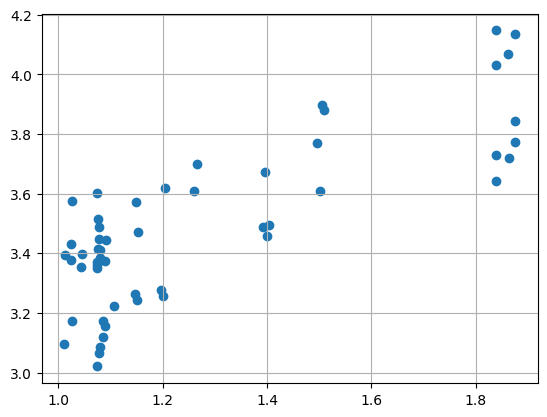

In [30]:
plt.scatter(airmass,eqwidth)
plt.grid()

# There are strong variations of the EQW value with the fit interval

## Attempt to quantify it using normalised fit

In [31]:
def eqw_stats(lambda_array, flux_array, lambda_min=500., lambda_max=1000., lambda_centre=762., make_plot=False):
    eqw_val_array = np.empty_like([])
    min_lin_interval = np.flip(np.linspace(absolute_min+2., lambda_centre-5., num=100, endpoint=True))
    max_lin_interval = np.linspace(lambda_centre+5., absolute_max-2., num=100, endpoint=True)
    linewidth_array = max_lin_interval-min_lin_interval
    
    loc_0 = -1
    tmp_avg_arr = np.empty_like([])
    tmp_med_arr = np.empty_like([])
    tmp_sig_arr = np.empty_like([])
    for min_lin, max_lin in zip(min_lin_interval, max_lin_interval): # symmetrical variation auround the O2 line for a first study
        loc_0 +=1 # provision for a plotting mechanism
        line_width = max_lin-min_lin  # provision for a plotting mechanism
        min_cont_interval = np.flip(np.linspace(absolute_min, min_lin-1., num=15, endpoint=True))
        max_cont_interval = np.linspace(max_lin+1., absolute_max, num=15, endpoint=True)
        contwidth_array = max_cont_interval-min_cont_interval
        
        loc_1 = -1
        tmp_eqw_array = np.empty_like([])
        for min_cont, max_cont in zip(min_cont_interval, max_cont_interval): # idem, symmetrical variation of the large interval used for fitting
            cont_width=max_cont-min_cont
            #print("o2 line width = {} nm, integration width = {} nm".format(line_width, cont_width))
            eqw_val = eqw_norm(lambda_array, flux_array, min_cont, max_cont, min_lin, max_lin, make_plot=False, central_lambda=lambda_centre)
            tmp_eqw_array = np.append(tmp_eqw_array, eqw_val)   
            
        eqw_val_array = np.append(eqw_val_array, tmp_eqw_array)
        tmp_avg_arr = np.append(tmp_avg_arr, np.average(tmp_eqw_array))
        tmp_med_arr = np.append(tmp_med_arr, np.median(tmp_eqw_array))
        tmp_sig_arr = np.append(tmp_sig_arr, np.std(tmp_eqw_array))
        
        if make_plot and (loc_0 % 10 == 0):
            fig0, ax0 = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)
            #ax0 = ax0.ravel()
            ax0.scatter(contwidth_array, tmp_eqw_array, label="EQW")
            ax0.axhline(tmp_avg_arr[-1], label="Average", color="orange")
            ax0.axhline(tmp_med_arr[-1], label="Median", color="g")
            ax0.legend()
            ax0.set_xlabel("Modelisation interval width (nm)")
            ax0.set_ylabel("EQW (nm)")
            fig0.suptitle("EQW distribution for O2-line within [{} nm, {} nm]".format(min_lin, max_lin))
            
    if make_plot:
            fig1, axs1 = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)
            #axs1 = axs1.ravel()
            axs1.errorbar(linewidth_array, tmp_avg_arr, yerr=tmp_sig_arr, marker="x", ls='', color="orange", elinewidth=.3, capsize=2, label="EQW")
            axs1.axhline(np.average(tmp_avg_arr), color="b", ls="--", label="Overall averaged EQW for this set")
            axs1.scatter(linewidth_array, tmp_med_arr, label="Median", marker=".", color="g")
            axs1.legend()
            axs1.set_xlabel("O2-line width (nm)")
            axs1.set_ylabel("EQW (nm) (averaged over total interval widths)")
            fig1.suptitle("EQW distribution in function of O2-line width")

    avg_eqw = np.average(eqw_val_array)
    med_eqw = np.median(eqw_val_array)
    sigma_eqw = np.std(eqw_val_array)
    
    return avg_eqw, med_eqw, sigma_eqw

Text(0.5, 0.98, 'Equivalent width values with errors due to the computation boundaries')

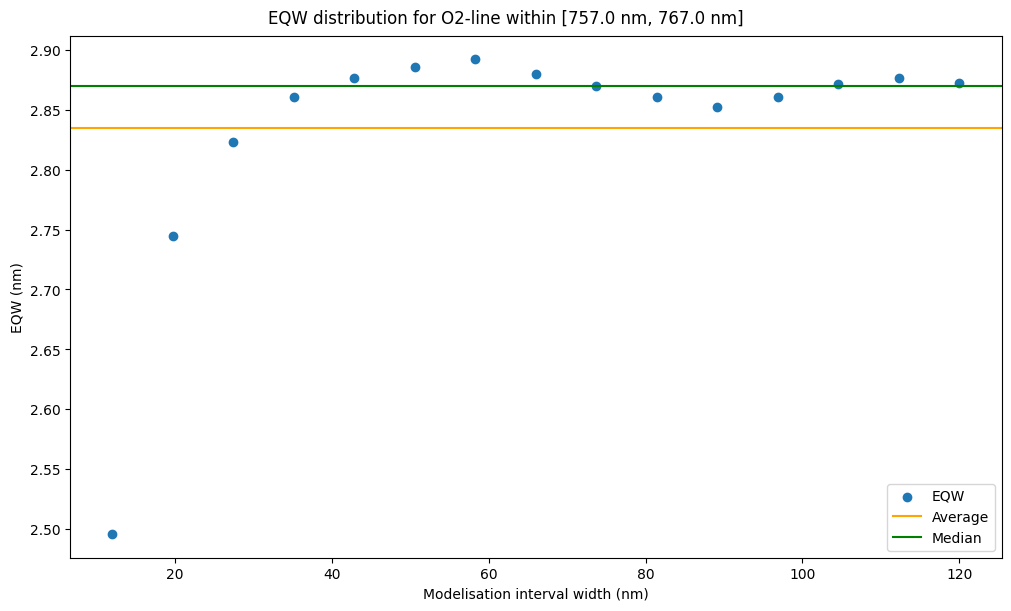

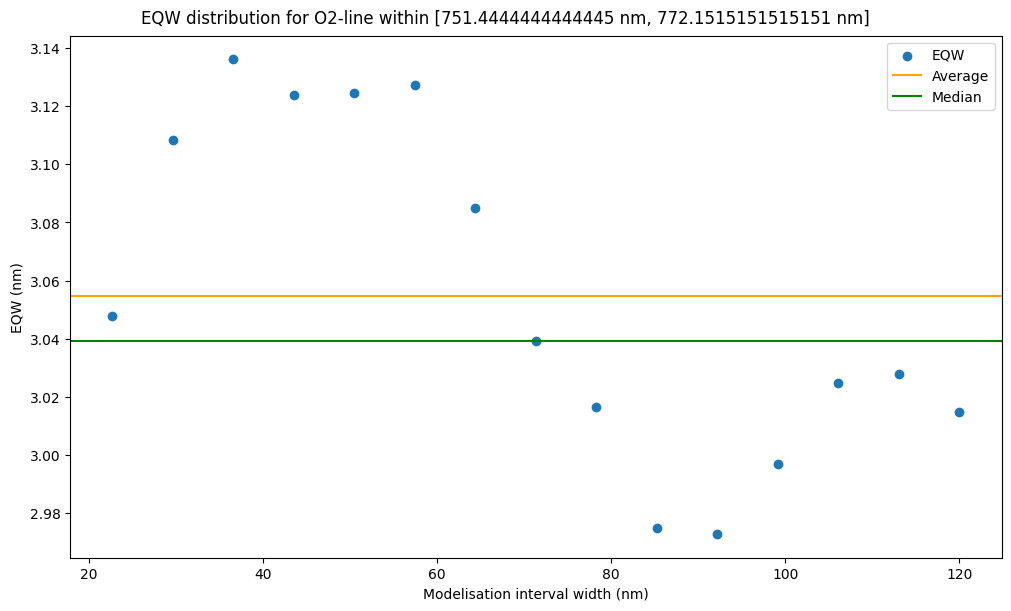

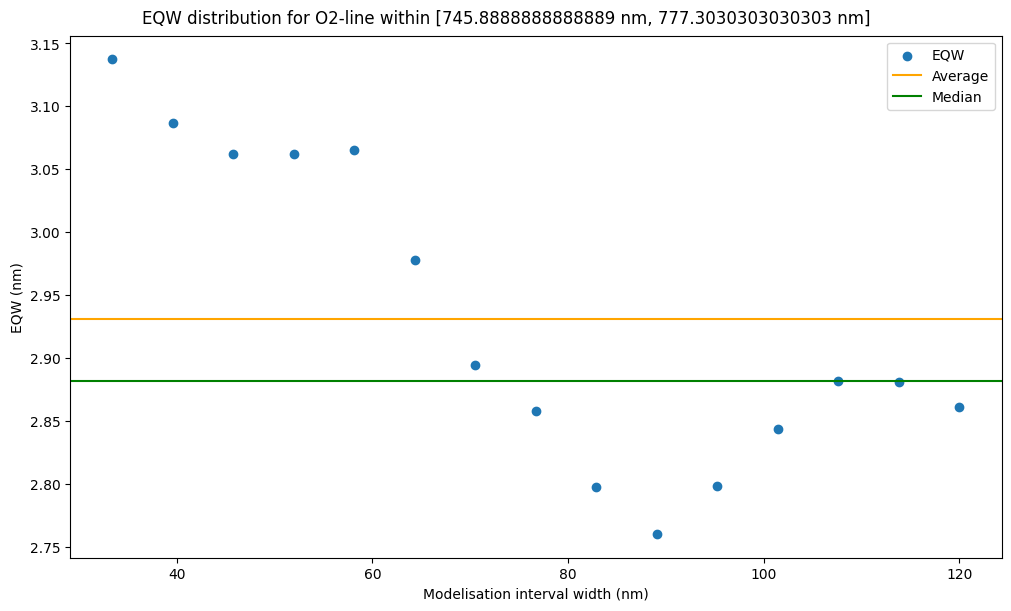

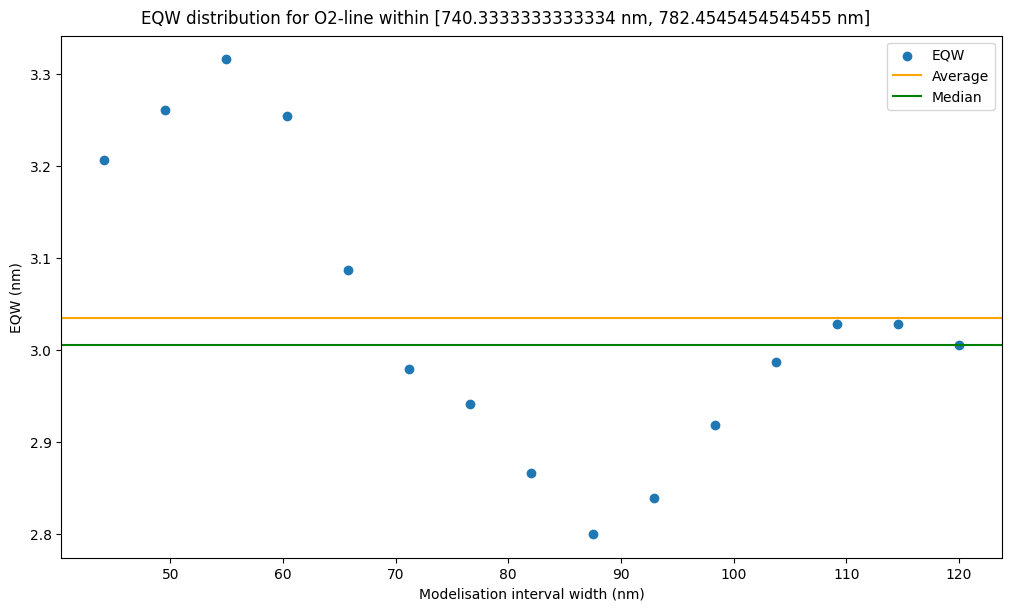

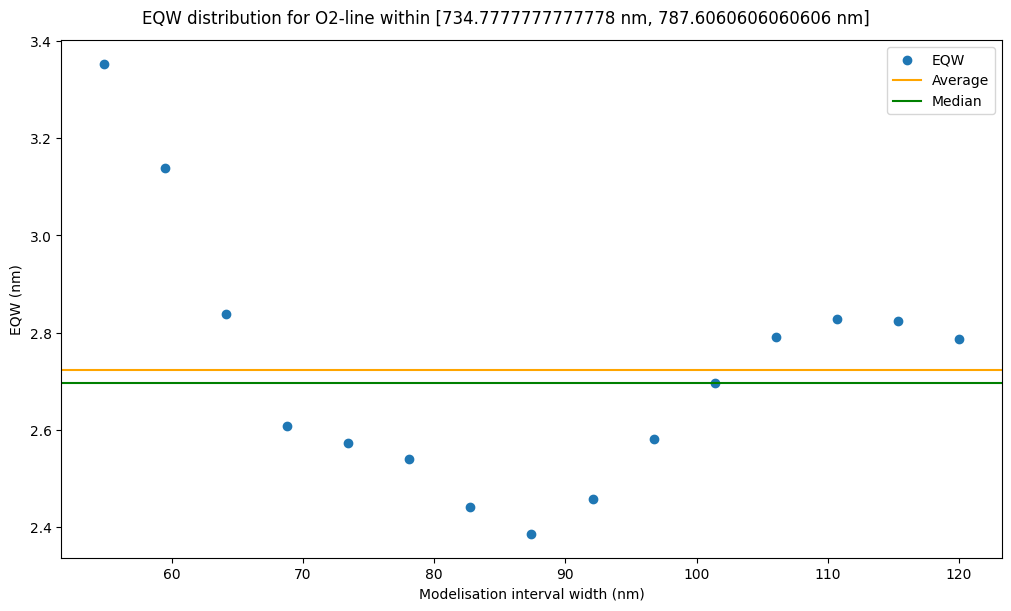

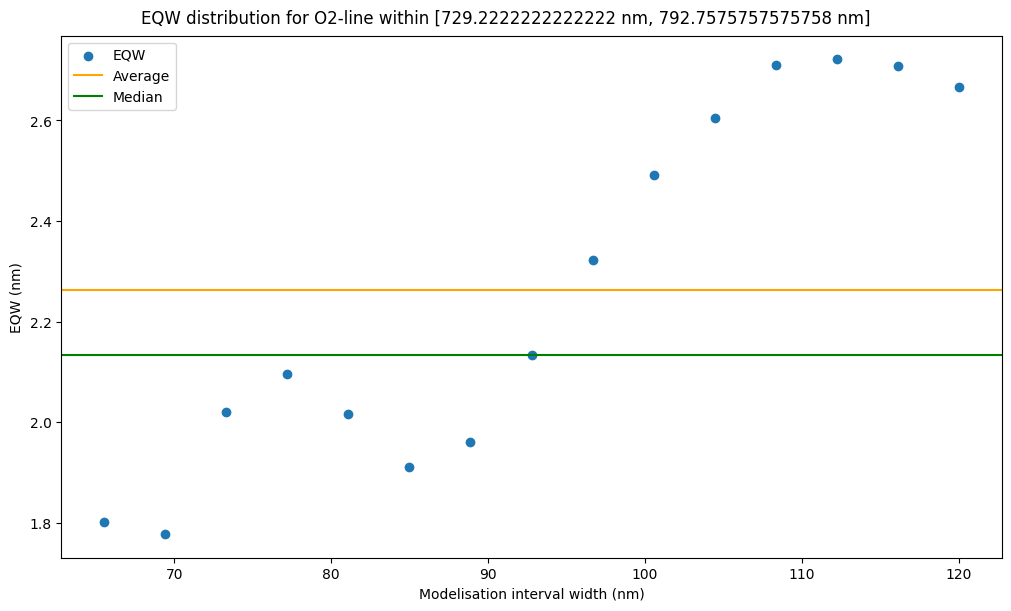

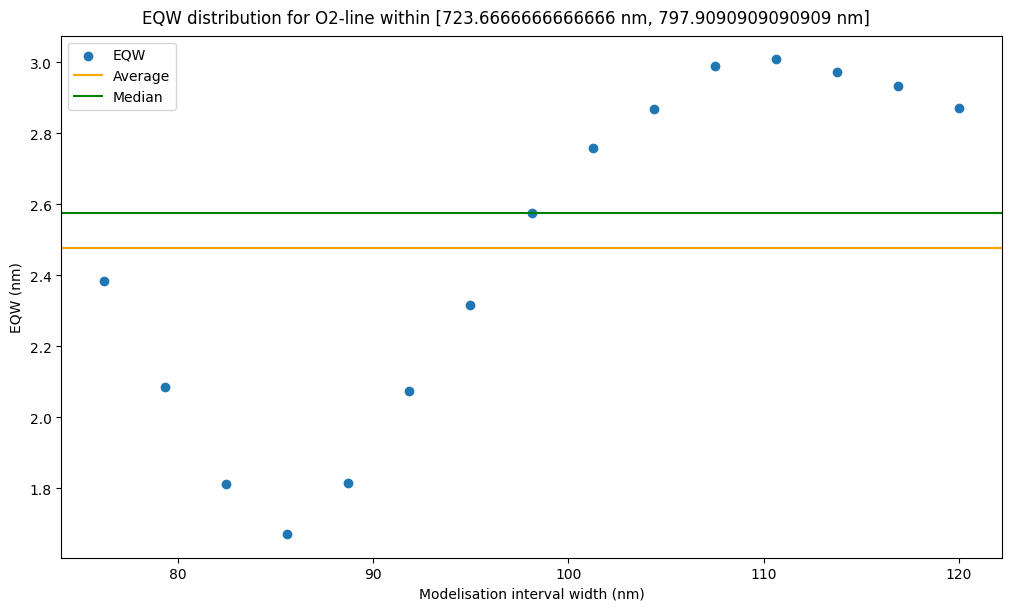

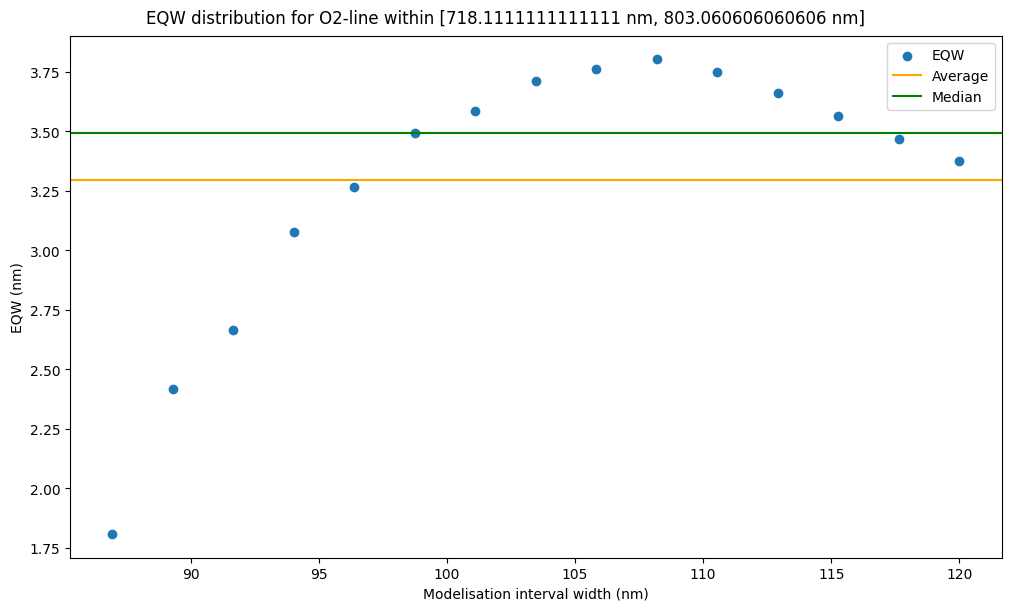

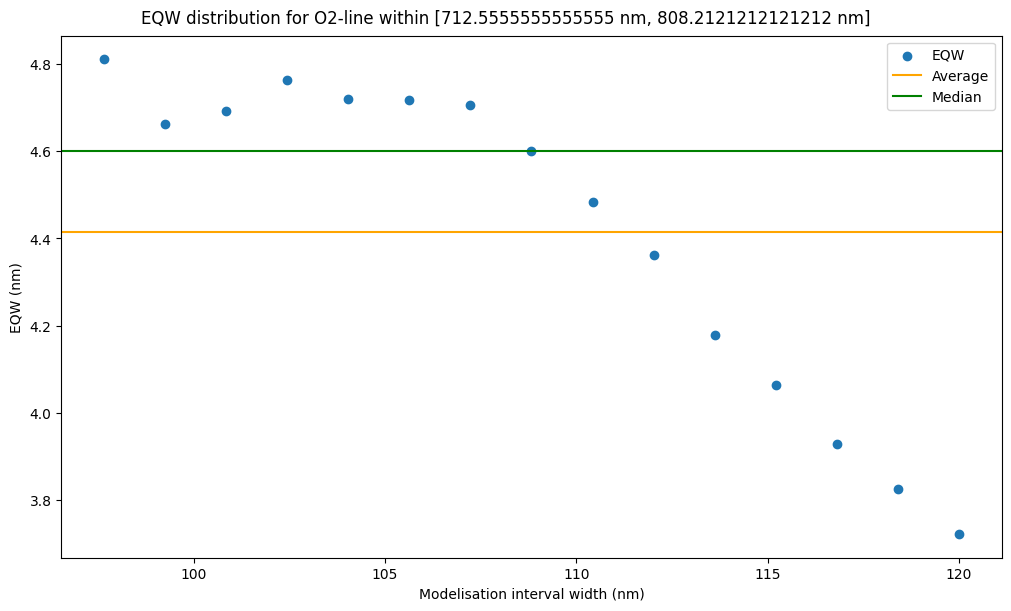

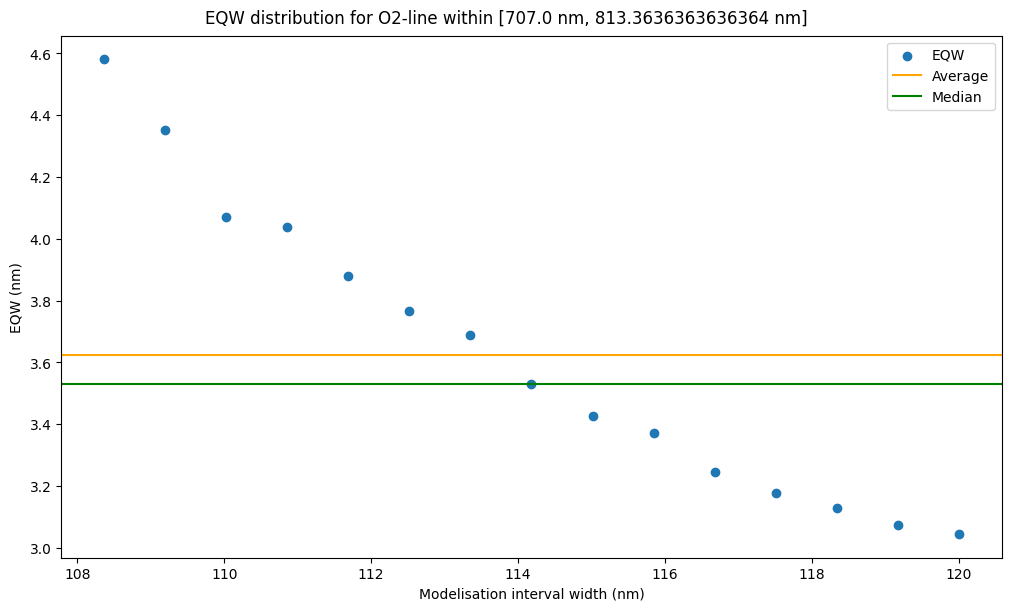

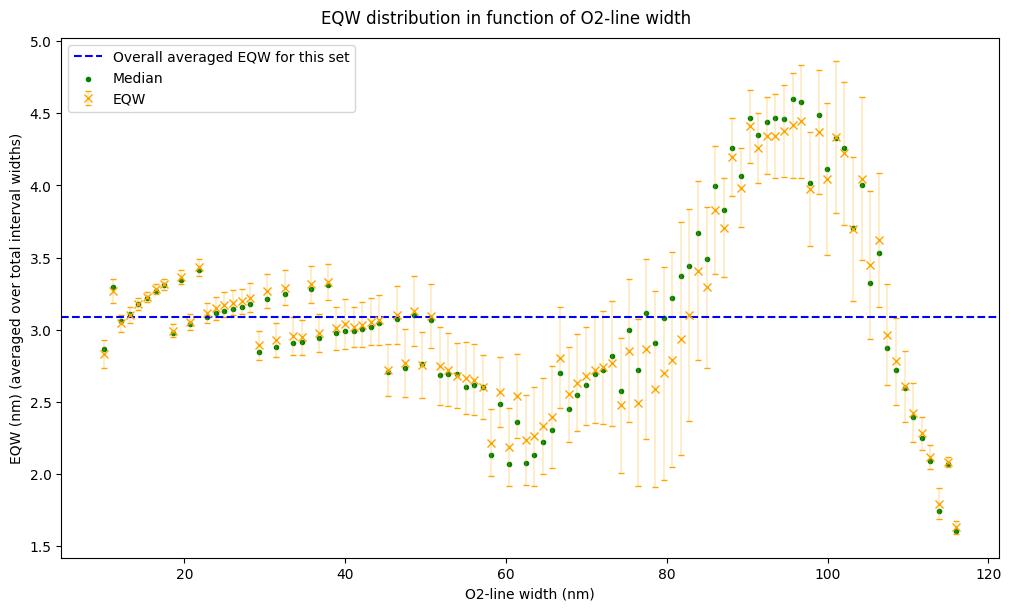

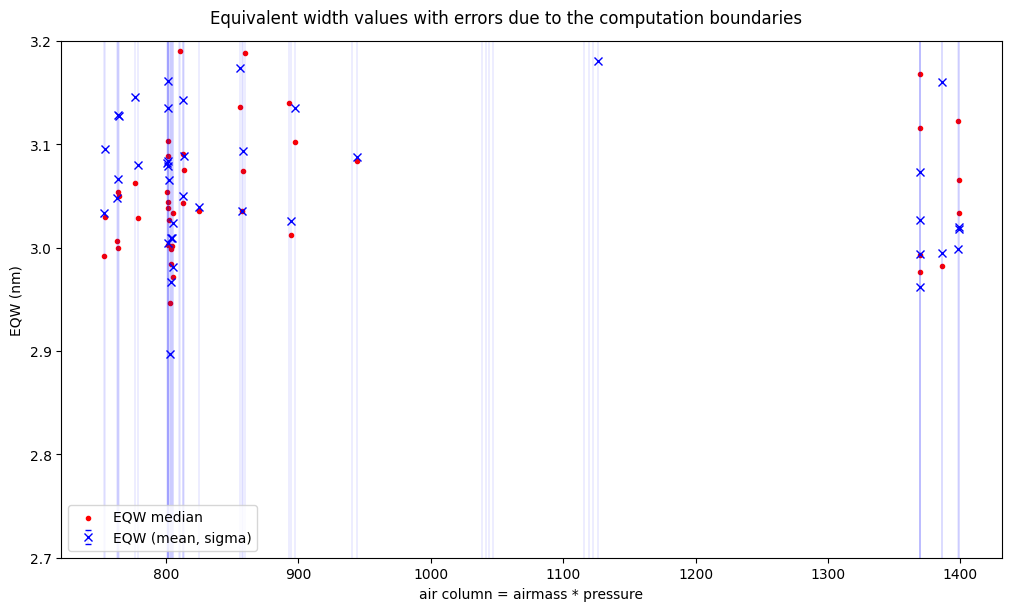

In [32]:
absolute_min, absolute_max = 700., 820.
fixed_o2_line = 762.
airmass = []
pressure = []

eqw_avgs = np.empty_like([])
eqw_meds = np.empty_like([])
eqw_sigs = np.empty_like([])
loc=-1
for spec in spec_dict_good:
    #print(spec)
    loc += 1
    airmass_ = spec_dict_good[spec]['airmass']
    pressure_ = spec_dict_good[spec]['pressure']   
    lambda_ = spec_dict_good[spec]['all_lambdas']
    flux_ = spec_dict_good[spec]['all_fluxes']

    if loc == 0 :
        eqw_avg, eqw_med, eqw_sigma = eqw_stats(lambda_, flux_, lambda_min=absolute_min, lambda_max=absolute_max, lambda_centre=fixed_o2_line, make_plot=True)
    else:
        eqw_avg, eqw_med, eqw_sigma = eqw_stats(lambda_, flux_, lambda_min=absolute_min, lambda_max=absolute_max, lambda_centre=fixed_o2_line, make_plot=False)

    airmass.append(airmass_)
    pressure.append(pressure_)
    eqw_avgs = np.append(eqw_avgs, eqw_avg)
    eqw_meds = np.append(eqw_meds, eqw_med)
    eqw_sigs = np.append(eqw_sigs, eqw_sigma)

airmass = np.array(airmass)
pressure = np.array(pressure)

fig, ax = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)
ax.errorbar(airmass*pressure, eqw_avgs, yerr=eqw_sigs, ls='', marker="x", color="b", elinewidth=.1, capsize=2, label="EQW (mean, sigma)")
ax.scatter(airmass*pressure, eqw_meds, marker=".", color="r", label="EQW median")
ax.set_xlabel("air column = airmass * pressure")
ax.set_ylabel("EQW (nm)")
ax.set_ylim(2.7,3.2)
ax.legend()
fig.suptitle("Equivalent width values with errors due to the computation boundaries")

We see that the Equivalent width is very sensible to the boundaries defined during the processed. Unfortunately these are user-defined simultaneously for all cases and therefore cannot be properly optimised. To decrease the uncertainty in EQW, we must find a way to compute and impose automatically some appropriate boundaries for each spectrum.

# Boundaries definition attempt

Here the idea is to model the whole slice of spectrum around the O2 line and extract the boundaries from this model. For instance, the attempt below aims to model the spectrum as a line (the continuum) minus a gaussian (the absorption band). The free parameters are then the two coefficients of the line (slope and root value), the mean and standard deviation of the normal law that defines the absorption band and a scale factor k. Then, the boundaries can be defined as the extremities of the spectrum slice for the continuum (not much importance because it is a line) and a certain number of sigmas around the mean so that xx% of the absorption due to the band is included in the interval.

## Model and fitting on an example

In [33]:
def fun_fit(x, a, b, mu, sigma, k):
    o2abs = norm(loc=mu, scale=sigma)
    return (a*x + b)-k*o2abs.pdf(x)

In [34]:
inputdir = '/pbs/throng/lsst/users/mrodrigu/desc/AuxTelComm/notebookccdm_gen3/bouguerlines/2022_09/data/'
file_label = 'run-auxtel-holo-{0}-{1}~{2}-config_DECONVOLUTION_PSF1D.pickle'
outdir = './output_files/'
if not os.path.exists(outdir):
    os.mkdir(outdir)
obs_date = '20220628'
filter = 'FELH0600'
disperser = 'holo4_003'
save_txt = False

inputfile = os.path.join(inputdir,file_label.format(obs_date,filter,disperser))
with open(inputfile,'rb') as f:
    spec_dict = pickle.load(f)

bad_spec_dict = {'20220628':[171,223,250,251,400,425,479,480,538,593,654,655,656,657,683,708],
                 '20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593]}
bad_spec = bad_spec_dict[obs_date]

spec_dict_good = {}
for key in spec_dict.keys():
    if int(spec_dict[key]['number']) not in bad_spec:
        spec_dict_good[key] = spec_dict[key]

ref_obs = 'exposure_2022062800143_postisrccd_spectrum.fits'
lambda_ref = spec_dict_good[ref_obs]['all_lambdas']
flux_ref = spec_dict_good[ref_obs]['all_fluxes']

In [35]:
abs_min, abs_max = 700, 800
mask = (lambda_ref >= abs_min) * (lambda_ref <= abs_max)
mod, cov = curve_fit(fun_fit, lambda_ref[mask], flux_ref[mask], p0=[1., 0.0, 762., 0.5, 1.0])
print(mod)

def spec_mod(x):
    return fun_fit(x, mod[0], mod[1], mod[2], mod[3], mod[4])

o2_band_centre = mod[2]
min_lin, max_lin = o2_band_centre - 3*mod[3], o2_band_centre + 3*mod[3]
min_cont, max_cont = o2_band_centre - 5*mod[3], o2_band_centre + 5*mod[3]

[-3.55817857e-15  3.57608692e-12  7.62277561e+02  2.80886742e+00
  2.50152072e-12]


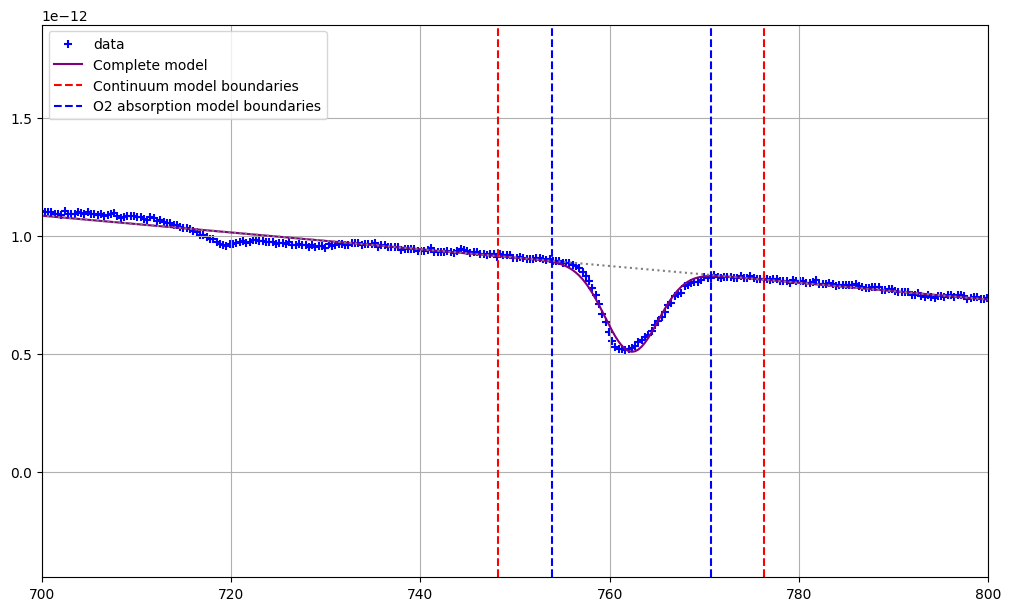

In [36]:
fig, ax = plt.subplots(1,1, figsize=(10,6), constrained_layout=True)
ax.scatter(spec_dict_good[ref_obs]['all_lambdas'], spec_dict_good[ref_obs]['all_fluxes'], marker="+", color="b", label="data")
ax.plot(spec_dict_good[ref_obs]['all_lambdas'], spec_mod(spec_dict_good[ref_obs]['all_lambdas']), ls="-", color="purple", label="Complete model")
ax.plot(spec_dict_good[ref_obs]['all_lambdas'], mod[0]*spec_dict_good[ref_obs]['all_lambdas'] + mod[1], ls=":", color="grey")
ax.set_xlim(abs_min, abs_max)
ax.axvline(x=min_cont,color='r',ls='--', label="Continuum model boundaries")
ax.axvline(x=max_cont,color='r',ls='--')
ax.axvline(x=min_lin,color='b',ls='--', label="O2 absorption model boundaries")
ax.axvline(x=max_lin,color='b',ls='--')
ax.grid()
ax.legend()

## Applying the method to one case to compute the equivalent width

In [37]:
def eqw_norm(x, flux, abs_min, abs_max, central_lambda=762., return_fit=False, make_plot=True, plot_name='test.png'): 
    
    def fun_fit(x, a, b, mu, sigma, k):
        o2abs = norm(loc=mu, scale=sigma)
        return (a*x + b)-k*o2abs.pdf(x)
    
    mask_for_fit = (x >= abs_min) * (x <= abs_max)
    p1, cov = curve_fit(fun_fit, x[mask_for_fit], flux[mask_for_fit], p0=[1., 0.0, central_lambda, 2.0, 1.0])
    
    o2_band_centre = p1[2]
    min_cont, max_cont = o2_band_centre - 5*p1[3], o2_band_centre + 5*p1[3]
    
    xmask_continuum = (x >= min_cont) * (x <= max_cont)
    mod, cov = curve_fit(fun_fit, x[xmask_continuum], flux[xmask_continuum], p0=[p1[0], p1[1], p1[2], p1[3], p1[4]])
    
    def spec_mod(x):
        return fun_fit(x, mod[0], mod[1], mod[2], mod[3], mod[4])
    
    def continuum(x):
        return mod[0]*x+mod[1]

    o2_band_centre = mod[2]
    min_lin, max_lin = o2_band_centre - 3*mod[3], o2_band_centre + 3*mod[3]
    min_cont, max_cont = o2_band_centre - 5*mod[3], o2_band_centre + 5*mod[3]
    xmask_continuum = (x>=min_cont)*(x<=max_cont)
    
    xline0 = x[mask_for_fit]
    fline0 = flux[mask_for_fit]
    
    xline = x[xmask_continuum]
    fline = flux[xmask_continuum]
    xmask_line = (xline>=min_lin)*(xline<=max_lin)
    xline_model = xline[xmask_line]
    fline_model = spec_mod(xline_model)
    
    def normed_cont(x): ## must return 1.
        return continuum(x) / continuum(x)
    def normed_spec(x):
        return spec_mod(x) / continuum(x)
    
    norm_array = continuum(xline)
    
    area_c = quad(normed_cont, min_lin, max_lin)[0]
    #area_ul = quad(normed_spec, min_lin, max_lin)[0]
    area_ul = np.trapz(fline[xmask_line]/norm_array[xmask_line],xline_model)
    #area_c = quad(normed_cont, min_cont, max_cont)[0]
    #area_ul = quad(normed_spec, min_cont, max_cont)[0]
    area_l = area_c-area_ul
    #print(area_c)
    #print(area_ul)
    #print(area_l)
    
    eqw = area_l #/cont_min
    #print('EQW = ',eqw)
    
    eqwmask = (xline_model>=o2_band_centre-eqw/2.)*(xline_model<=o2_band_centre+eqw/2.)
    #print(continuum)
    #print(xmin_line-eqw/2.,xmin_line+eqw/2.)
    
    if make_plot:
        fig, axs=plt.subplots(1,2,figsize=(10,6), constrained_layout=True)
        axs=axs.ravel()
        axs[0].scatter(xline0, fline0, marker="+", label="Observed fluxes")
        axs[0].plot(xline0, continuum(xline0), ls='--', color='orange', label="Continuum model")
        axs[0].plot(xline0, spec_mod(xline0), ls='-', color='purple', label="Flux model")
        axs[0].axvline(x=min_lin,color='b',ls='--', label="3 sigma : O2 absorption model boundaries")
        axs[0].axvline(x=max_lin,color='b',ls='--')
        axs[0].axvline(x=min_cont,color='r',ls='--', label="5 sigma : boundaries of the model")
        axs[0].axvline(x=max_cont,color='r',ls='--')
        axs[0].fill_between(xline_model, continuum(xline_model), fline[xmask_line], color='gray',alpha=0.2, label="Ref. surface")
        #axs[0].fill_between(xline_model[eqwmask], continuum(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        #axs[0].fill_between(xline_model, continuum(xline_model), spec_mod(xline_model), color='gray',alpha=0.2, label="Ref. surface")
        axs[0].fill_between(xline_model[eqwmask], continuum(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        axs[1].set_xlabel(r'$\lambda \, [nm]$',fontsize=12)
        axs[0].set_ylabel(r'$\gamma \, [s \cdot cm^2 \cdot nm]$',fontsize=12)
        axs[0].grid()
        axs[0].legend(loc="lower right")
        
        
        axs[1].scatter(xline, fline/norm_array, marker="+", label="Normalised observed fluxes")
        axs[1].plot(xline, normed_cont(xline), ls='--', color='orange', label="Continuum model")
        axs[1].plot(xline, normed_spec(xline), ls='-', color='purple', label="Flux model")
        axs[1].axvline(x=min_lin,color='b',ls='--', label="3 sigma : O2 absorption model boundaries")
        axs[1].axvline(x=max_lin,color='b',ls='--')
        axs[1].axvline(x=min_cont,color='r',ls='--', label="5 sigma : boundaries of the model")
        axs[1].axvline(x=max_cont,color='r',ls='--')
        axs[1].fill_between(xline_model, normed_cont(xline_model), fline[xmask_line]/norm_array[xmask_line], color='gray',alpha=0.2, label="Ref. surface")
        #axs[1].fill_between(xline_model[eqwmask], normed_cont(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        #axs[1].fill_between(xline_model, normed_cont(xline_model), normed_spec(xline_model), color='gray',alpha=0.2, label="Ref. surface")
        axs[1].fill_between(xline_model[eqwmask], normed_cont(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        axs[1].set_xlabel(r'$\lambda \, [nm]$',fontsize=12)
        axs[1].set_ylabel(r'$\gamma \, / continuum [-]$',fontsize=12)
        axs[1].grid()
        axs[1].legend(loc="lower right")
        '''
        plot_outdir = 'output_plots/eqw_line_fit_{0}/'.format(source_spec)
        if os.path.exists(plot_outdir)==False:
            os.mkdir(plot_outdir)
        plt.savefig(plot_outdir+plot_name) 
        '''
    if return_fit:
        return eqw, mod, xline, fline, continuum(xline)
    else:
        return eqw

Equivalent width EQW=3.2375849206173015


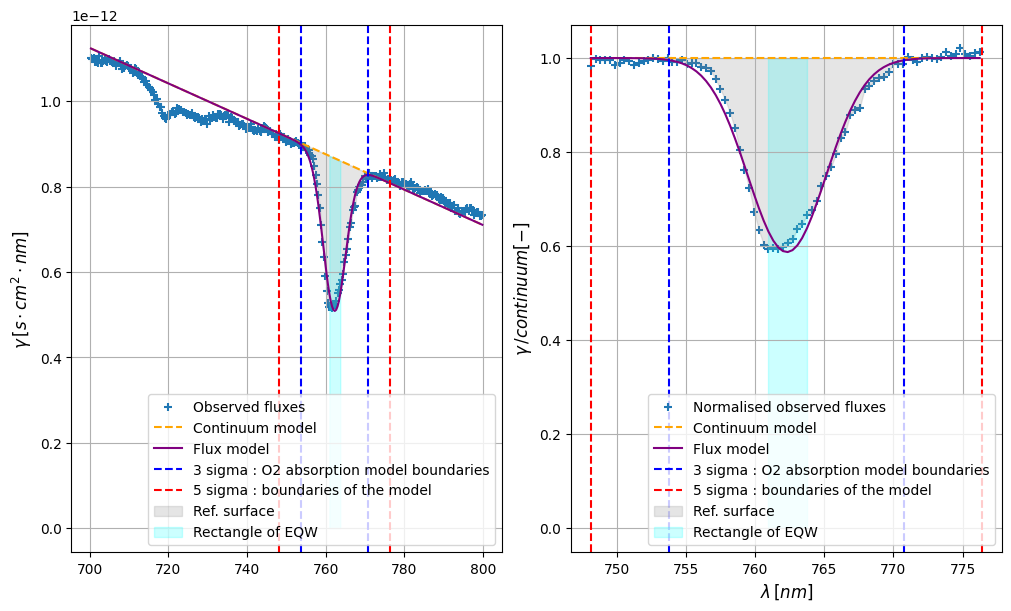

In [38]:
eqw_val = eqw_norm(lambda_ref, flux_ref, abs_min, abs_max, make_plot=True)
print("Equivalent width EQW={}".format(eqw_val))

## Now let us try to iterate as before

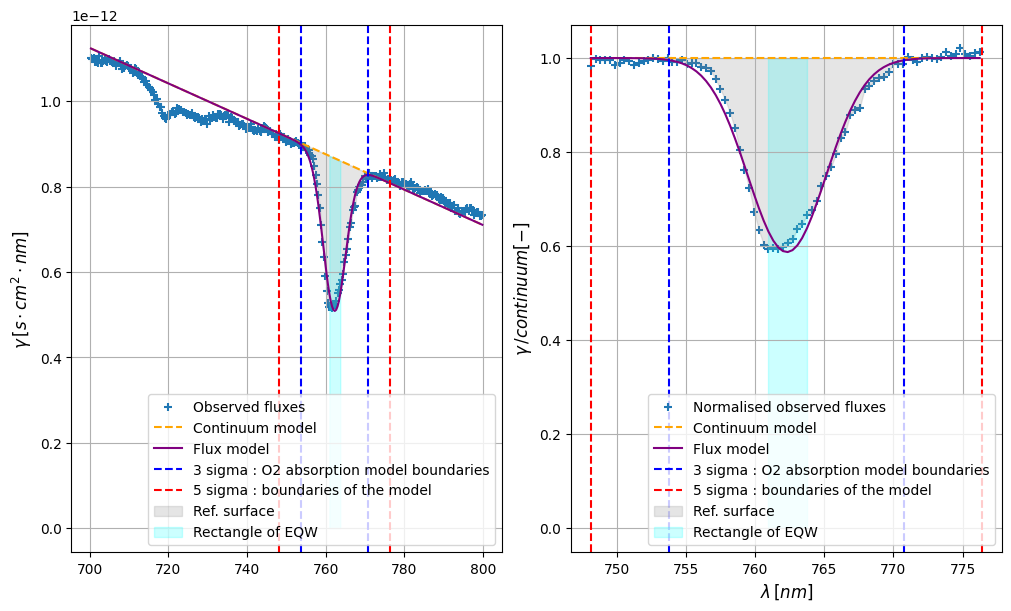

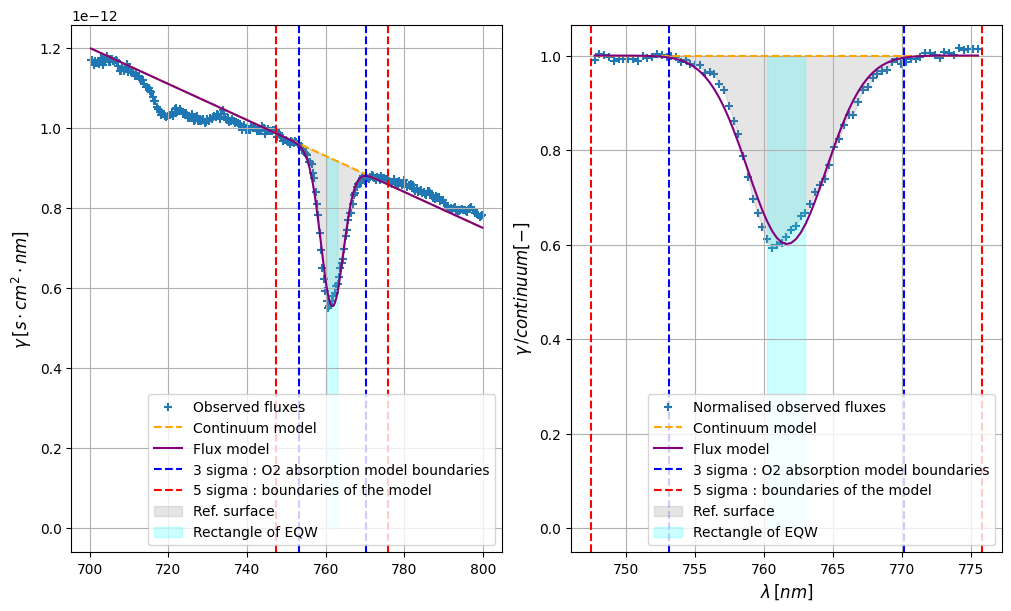

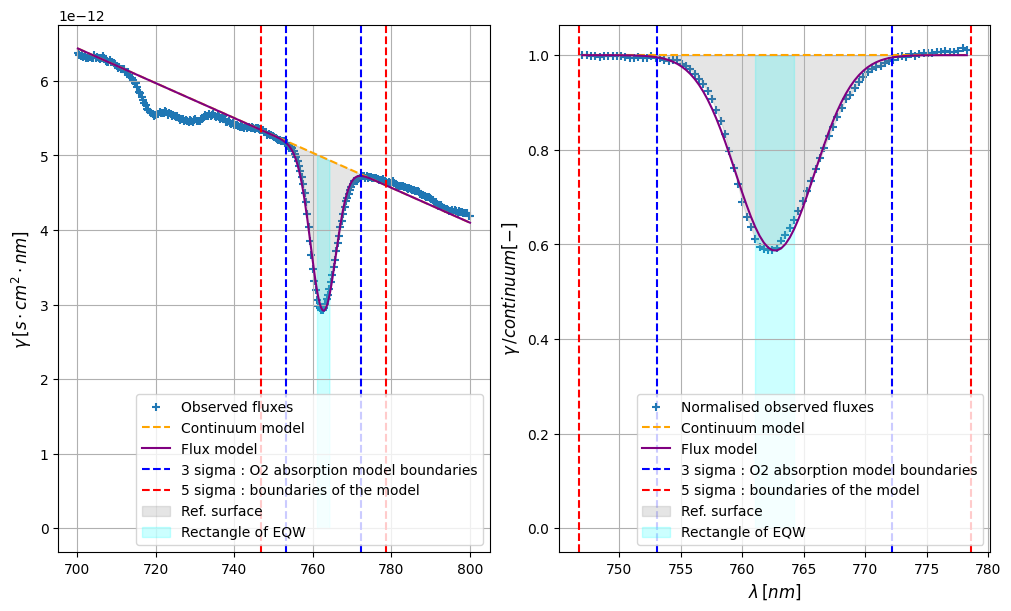

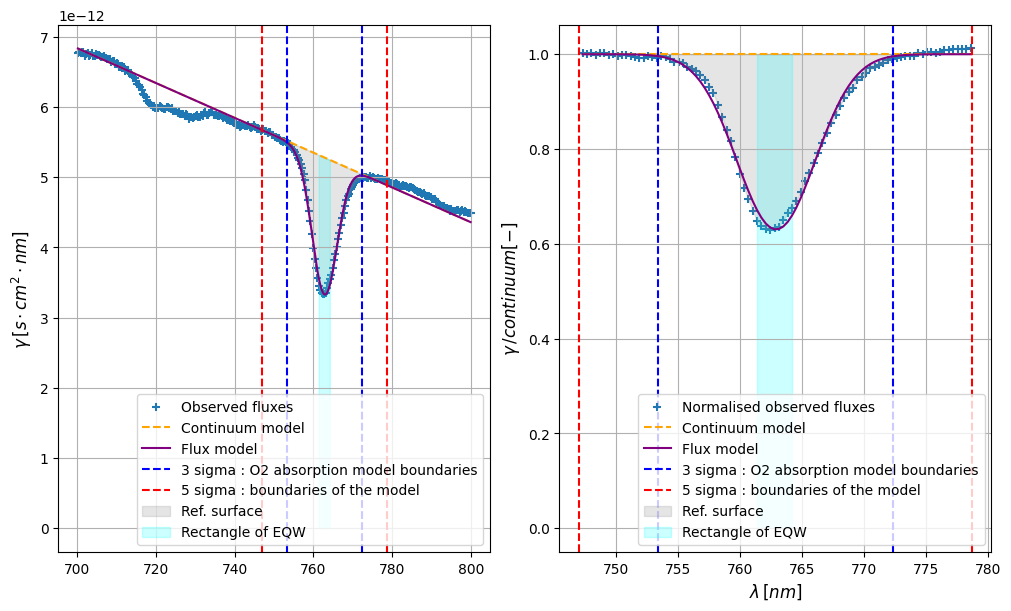

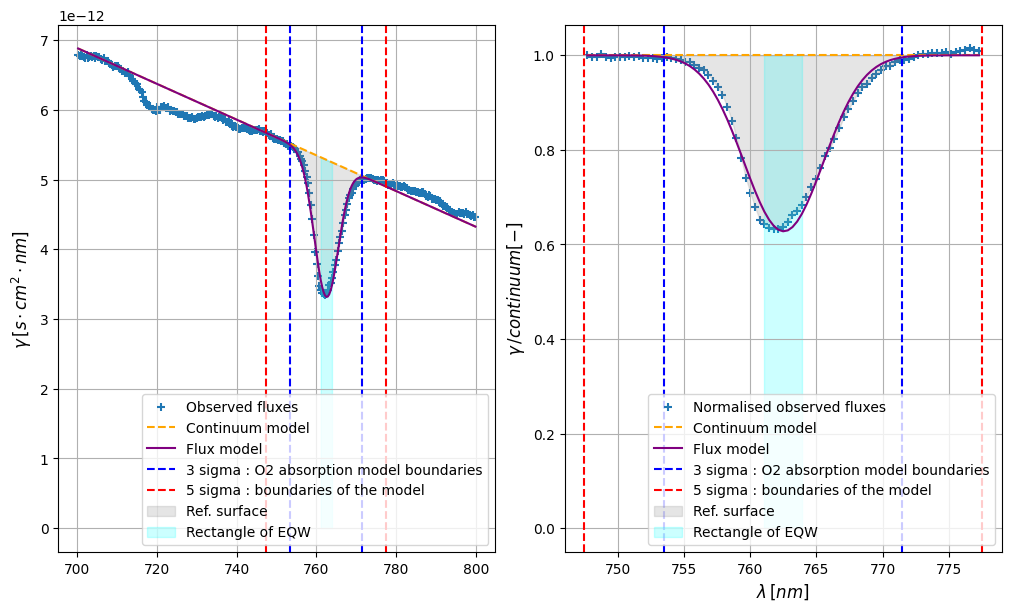

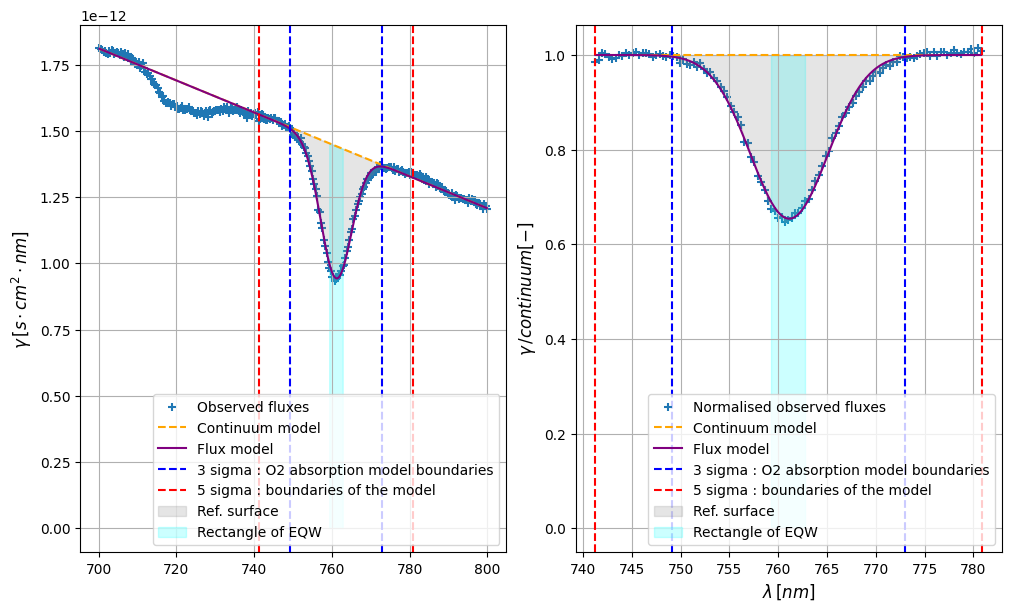

In [39]:
airmass = []
pressure = []
eqwidth = []
loc=-1
for spec in spec_dict_good:
    #print(spec)
    loc += 1
    airmass_ = spec_dict_good[spec]['airmass']
    pressure_ = spec_dict_good[spec]['pressure']
    
    lambda_ = spec_dict_good[spec]['all_lambdas']
    flux_ = spec_dict_good[spec]['all_fluxes']
    #print(lambda_)
    #print(flux_)
    
    if loc%10 == 0 :
        eqw_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=True)
    else:
        eqw_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=False)
    
    '''
    if eqwdb_<0.:
        print(seqn)
        plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
        eqwdb_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    elif eqwdf_<0.:
        print(seqn)
        plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
        eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    
    plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
    eqw0_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    
    plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
    eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    '''
    airmass.append(airmass_)
    pressure.append(pressure_)
    eqwidth.append(eqw_)
airmass = np.array(airmass)
pressure = np.array(pressure)
eqwidth = np.array(eqwidth)
if save_txt:
    data = np.transpose(np.array([airmass,pressure,eqwidth]))
    np.savetxt('eqw_data_{0}_{1}_{2}.txt'.format(obs_date,filter,disperser),data,header='airmass pressure eqw')

Text(0.5, 0.98, 'Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit')

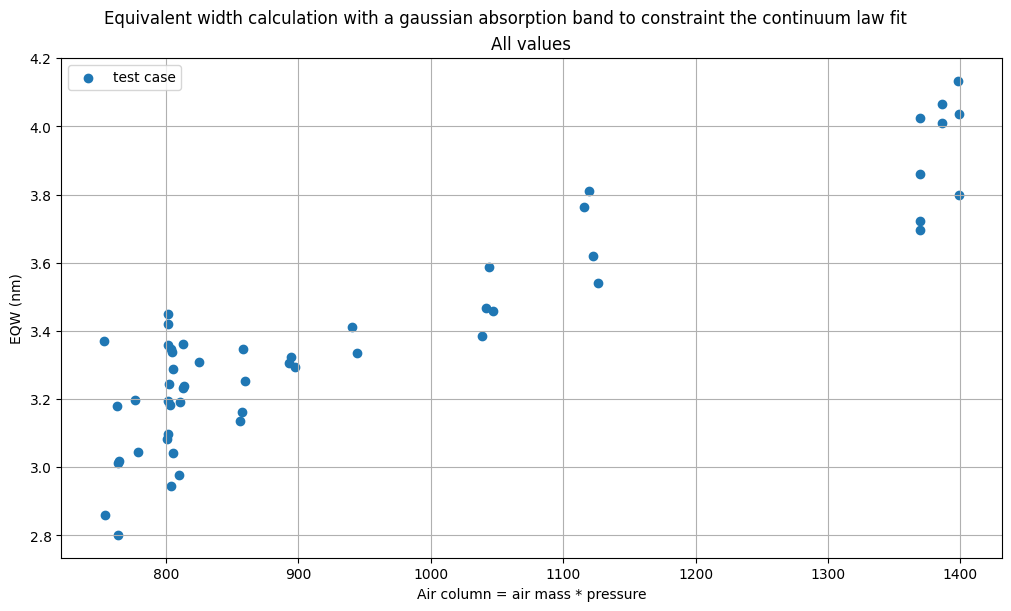

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)
#axs=axs.ravel()
axs.scatter(airmass*pressure, eqwidth, label="test case")
axs.grid()
axs.set_xlabel("Air column = air mass * pressure")
axs.set_ylabel("EQW (nm)")
axs.set_title("All values")
axs.legend()

#axs[1].scatter(airmass*pressure, eqwidth, label="test case")
#axs[1].set_ylim(2.7, 3.6)
#axs[1].grid()
#axs[1].set_xlabel("Air column = air mass * pressure")
#axs[1].set_ylabel("EQW (nm)")
#axs[1].set_title("Without obvious outliers")

fig.suptitle("Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit")

## Now we try to include error bars computation within the functions

In [41]:
#def continuum_error(l0, sigma_a, sigma_b, sigma_c, sigma_d):
#    return np.sqrt( np.power((sigma_a*np.power(l0,3.)), 2.) + numpy.power(sigma_b*numpy.power(l0, 2.), 2.) + numpy.power(sigma_c*l0, 2.) + numpy.power(sigma_d, 2.) )
#
def continuum_error(l0, sigma_a, sigma_b):
    return np.sqrt( np.power(sigma_a*l0, 2.) + np.power(sigma_b, 2.) )

def area_ul_error(flux_error, lambda_vec):
    delta_lambda = np.mean( np.diff(lambda_vec) )
    return np.sqrt( np.sum( np.power(flux_error, 2.) ) * np.power(delta_lambda, 2.) )

def area_l_error(sigma_area_cont, sigma_area_ul):
    return np.sqrt( np.power(sigma_area_cont, 2.) + np.power(sigma_area_ul, 2.) )

def eqw_error(cont_at_line, line_area, sigma_cont, sigma_area_line):
    sigma2_eqw = np.power(sigma_area_line / cont_at_line, 2.) + np.power(line_area*sigma_cont / np.power(cont_at_line, 2.), 2.)
    return np.sqrt(sigma2_eqw)

In [42]:
def eqw_norm(x, flux, abs_min, abs_max, central_lambda=762., return_fit=False, make_plot=True, plot_name='test.png'): 
    
    def fun_fit(x, a, b, mu, sigma, k):
        o2abs = norm(loc=mu, scale=sigma)
        return (a*x + b)-k*o2abs.pdf(x)
    
    def continuum_error(l0, sigma_a, sigma_b):
        return np.sqrt( np.power(sigma_a*l0, 2.) + np.power(sigma_b, 2.) )

    def area_ul_error(flux_error, lambda_vec):
        delta_lambda = np.mean( np.diff(lambda_vec) )
        return np.sqrt( np.sum( np.power(flux_error, 2.) ) * np.power(delta_lambda, 2.) )

    def area_l_error(sigma_area_cont, sigma_area_ul):
        return np.sqrt( np.power(sigma_area_cont, 2.) + np.power(sigma_area_ul, 2.) )

    def eqw_error(cont_at_line, line_area, sigma_cont, sigma_area_line):
        sigma2_eqw = np.power(sigma_area_line / cont_at_line, 2.) + np.power(line_area*sigma_cont / np.power(cont_at_line, 2.), 2.)
        return np.sqrt(sigma2_eqw)
    
    mask_for_fit = (x >= abs_min) * (x <= abs_max)
    p1, cov = curve_fit(fun_fit, x[mask_for_fit], flux[mask_for_fit], p0=[1., 0.0, central_lambda, 2.0, 1.0])
    
    o2_band_centre = p1[2]
    min_cont, max_cont = o2_band_centre - 5*p1[3], o2_band_centre + 5*p1[3]
    
    xmask_continuum = (x >= min_cont) * (x <= max_cont)
    mod, cov = curve_fit(fun_fit, x[xmask_continuum], flux[xmask_continuum], p0=[p1[0], p1[1], p1[2], p1[3], p1[4]])
    
    def spec_mod(x):
        return fun_fit(x, mod[0], mod[1], mod[2], mod[3], mod[4])
    
    def continuum(x):
        return mod[0]*x+mod[1]

    o2_band_centre = mod[2]
    min_lin, max_lin = o2_band_centre - 3*mod[3], o2_band_centre + 3*mod[3]
    min_cont, max_cont = o2_band_centre - 5*mod[3], o2_band_centre + 5*mod[3]
    xmask_continuum = (x>=min_cont)*(x<=max_cont)
    
    xline0 = x[mask_for_fit]
    fline0 = flux[mask_for_fit]
    
    xline = x[xmask_continuum]
    fline = flux[xmask_continuum]
    xmask_line = (xline>=min_lin)*(xline<=max_lin)
    xline_model = xline[xmask_line]
    fline_model = spec_mod(xline_model)
    
    def normed_cont(x): ## must return 1.
        return continuum(x) / continuum(x)
    def normed_spec(x):
        return spec_mod(x) / continuum(x)
    
    norm_array = continuum(xline)
    
    area_c, area_c_err = quad(normed_cont, min_lin, max_lin)
    #area_ul = quad(normed_spec, min_lin, max_lin)[0]
    area_ul = np.trapz(fline[xmask_line]/norm_array[xmask_line], xline_model)
    #area_c = quad(normed_cont, min_cont, max_cont)[0]
    #area_ul = quad(normed_spec, min_cont, max_cont)[0]
    area_l = area_c-area_ul
    #print(area_c)
    #print(area_ul)
    #print(area_l)
    
    cont_min = continuum(o2_band_centre)
    eqw = area_l #/cont_min
    #print('EQW = ',eqw)
        
    sigma_a = np.sqrt(cov[0,0])
    sigma_b = np.sqrt(cov[1,1])
    delta_line = np.sqrt(cov[2,2])
    
    #print(cont_min)
    #print(area_l)
    #print(area_c_err)
    
    cont_err_ = continuum_error(central_lambda, sigma_a, sigma_b)
    #print(cont_err_)
    
    area_ul_err_ = area_ul_error(fline[xmask_line]/continuum(norm_array[xmask_line]), xline_model)
    #print(area_ul_err_)
    
    area_l_err_ = area_l_error(area_c_err, area_ul_err_)
    #print(area_l_err_)
    
    #eqw_err_ = eqw_error(cont_min, area_l_, cont_err_, area_l_err_)
    eqw_err_ = eqw_error(1., area_l, cont_err_, area_l_err_)
    #print(eqw_err_)
    
    #print('----------')
    
    eqwmask = (xline_model>=o2_band_centre-eqw/2.)*(xline_model<=o2_band_centre+eqw/2.)
    #print(continuum)
    #print(xmin_line-eqw/2.,xmin_line+eqw/2.)
    
    if make_plot:
        fig, axs=plt.subplots(1,2,figsize=(10,6), constrained_layout=True)
        axs=axs.ravel()
        axs[0].scatter(xline0, fline0, marker="+", label="Observed fluxes")
        axs[0].plot(xline0, continuum(xline0), ls='--', color='orange', label="Continuum model")
        axs[0].plot(xline0, spec_mod(xline0), ls='-', color='purple', label="Flux model")
        axs[0].axvline(x=min_lin,color='b',ls='--', label="3 sigma : O2 absorption model boundaries")
        axs[0].axvline(x=max_lin,color='b',ls='--')
        axs[0].axvline(x=min_cont,color='r',ls='--', label="5 sigma : boundaries of the model")
        axs[0].axvline(x=max_cont,color='r',ls='--')
        axs[0].fill_between(xline_model, continuum(xline_model), fline[xmask_line], color='gray',alpha=0.2, label="Ref. surface")
        #axs[0].fill_between(xline_model[eqwmask], continuum(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        #axs[0].fill_between(xline_model, continuum(xline_model), spec_mod(xline_model), color='gray',alpha=0.2, label="Ref. surface")
        axs[0].fill_between(xline_model[eqwmask], continuum(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        axs[1].set_xlabel(r'$\lambda \, [nm]$',fontsize=12)
        axs[0].set_ylabel(r'$\gamma \, [s \cdot cm^2 \cdot nm]$',fontsize=12)
        axs[0].grid()
        axs[0].legend(loc="lower right")
        
        
        axs[1].scatter(xline, fline/norm_array, marker="+", label="Normalised observed fluxes")
        axs[1].plot(xline, normed_cont(xline), ls='--', color='orange', label="Continuum model")
        axs[1].plot(xline, normed_spec(xline), ls='-', color='purple', label="Flux model")
        axs[1].axvline(x=min_lin,color='b',ls='--', label="3 sigma : O2 absorption model boundaries")
        axs[1].axvline(x=max_lin,color='b',ls='--')
        axs[1].axvline(x=min_cont,color='r',ls='--', label="5 sigma : boundaries of the model")
        axs[1].axvline(x=max_cont,color='r',ls='--')
        axs[1].fill_between(xline_model, normed_cont(xline_model), fline[xmask_line]/norm_array[xmask_line], color='gray',alpha=0.2, label="Ref. surface")
        #axs[1].fill_between(xline_model[eqwmask], normed_cont(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        #axs[1].fill_between(xline_model, normed_cont(xline_model), normed_spec(xline_model), color='gray',alpha=0.2, label="Ref. surface")
        axs[1].fill_between(xline_model[eqwmask], normed_cont(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        axs[1].set_xlabel(r'$\lambda \, [nm]$',fontsize=12)
        axs[1].set_ylabel(r'$\gamma \, / continuum [-]$',fontsize=12)
        axs[1].grid()
        axs[1].legend(loc="lower right")
        '''
        plot_outdir = 'output_plots/eqw_line_fit_{0}/'.format(source_spec)
        if os.path.exists(plot_outdir)==False:
            os.mkdir(plot_outdir)
        plt.savefig(plot_outdir+plot_name) 
        '''
    if return_fit:
        return eqw, eqw_err_, mod, cov, xline, fline, continuum(xline), cont_min, area_l, area_c_err
    else:
        return eqw, eqw_err_

In [43]:
inputdir = '/pbs/throng/lsst/users/mrodrigu/desc/AuxTelComm/notebookccdm_gen3/bouguerlines/2022_09/data/'
file_label = 'run-auxtel-holo-{0}-{1}~{2}-config_DECONVOLUTION_PSF1D.pickle'
outdir = './output_files/'
if not os.path.exists(outdir):
    os.mkdir(outdir)
obs_date = '20220628'
filter = 'FELH0600'
disperser = 'holo4_003'
save_txt = False

inputfile = os.path.join(inputdir,file_label.format(obs_date,filter,disperser))
with open(inputfile,'rb') as f:
    spec_dict = pickle.load(f)

bad_spec_dict = {'20220628':[171,223,250,251,400,425,479,480,538,593,654,655,656,657,683,708],
                 '20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593]}
bad_spec = bad_spec_dict[obs_date]

spec_dict_good = {}
for key in spec_dict.keys():
    if int(spec_dict[key]['number']) not in bad_spec:
        spec_dict_good[key] = spec_dict[key]

ref_obs = 'exposure_2022062800143_postisrccd_spectrum.fits'
lambda_ref = spec_dict_good[ref_obs]['all_lambdas']
flux_ref = spec_dict_good[ref_obs]['all_fluxes']

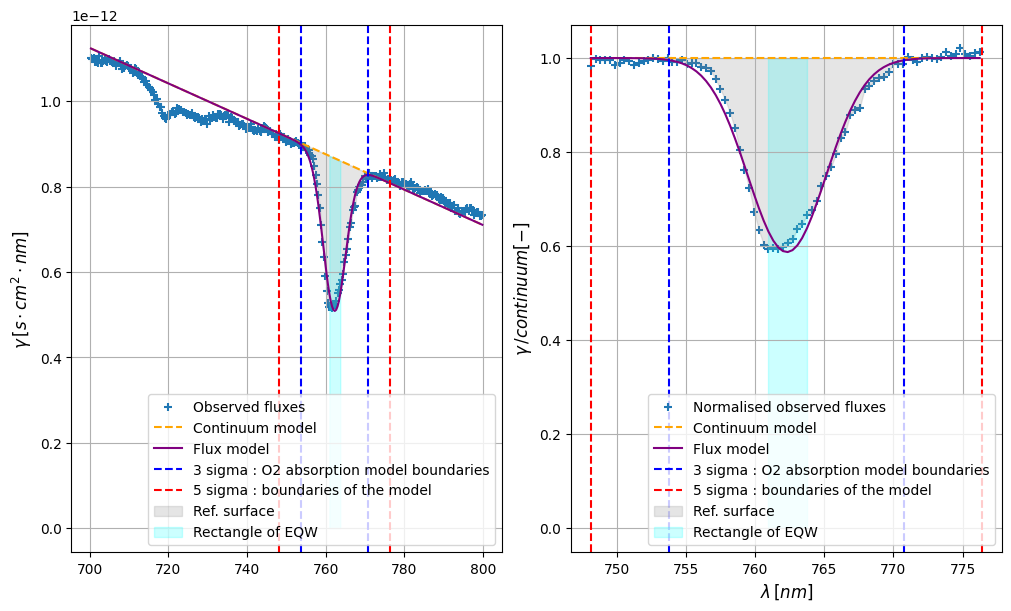

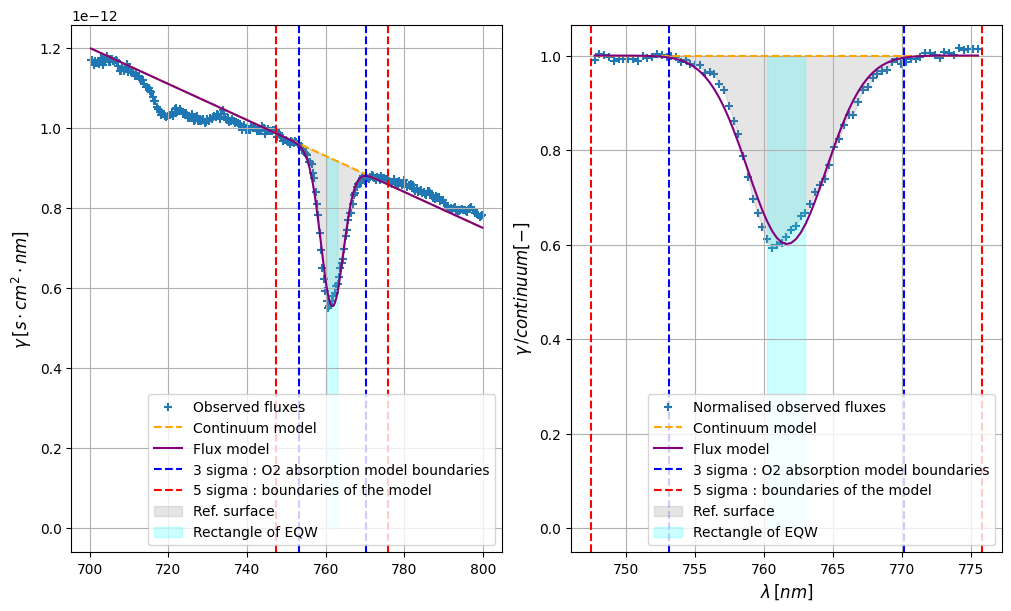

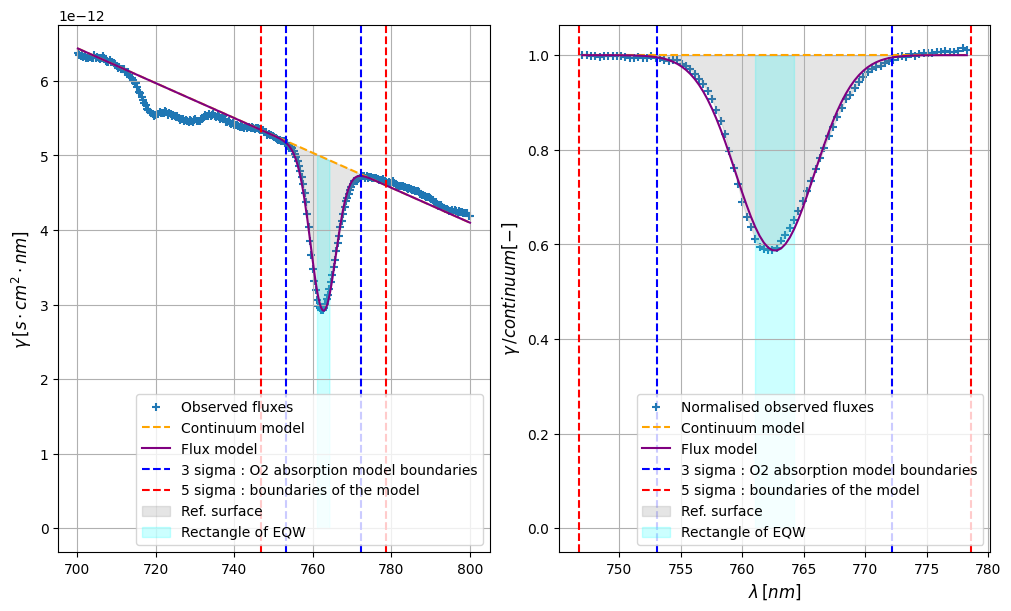

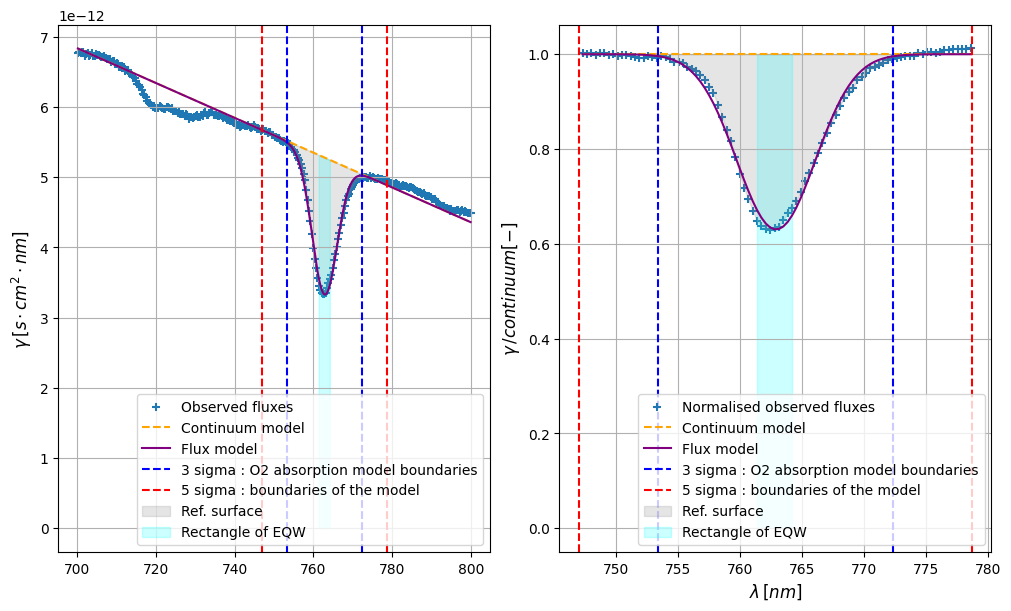

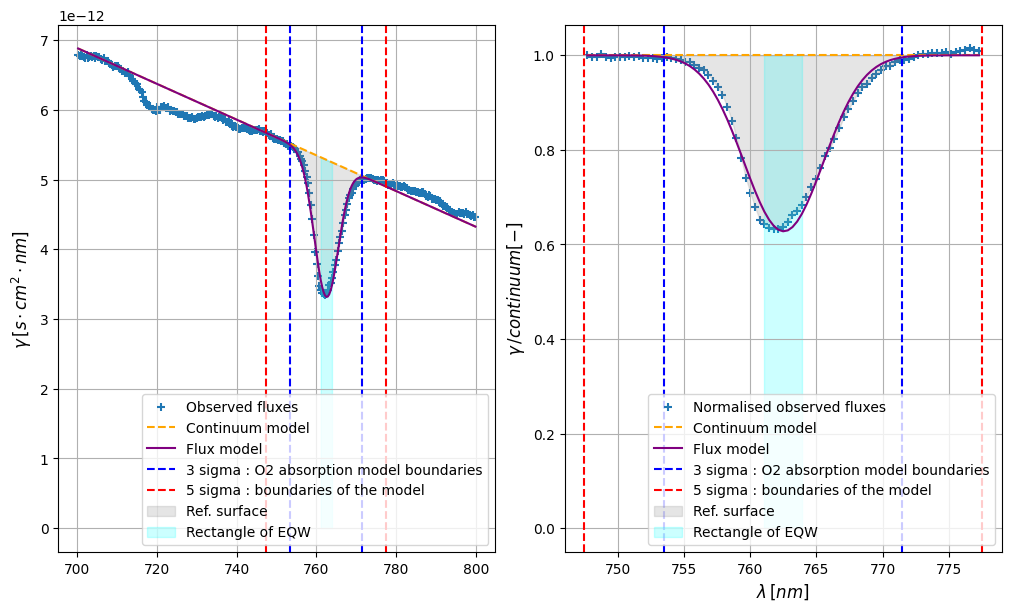

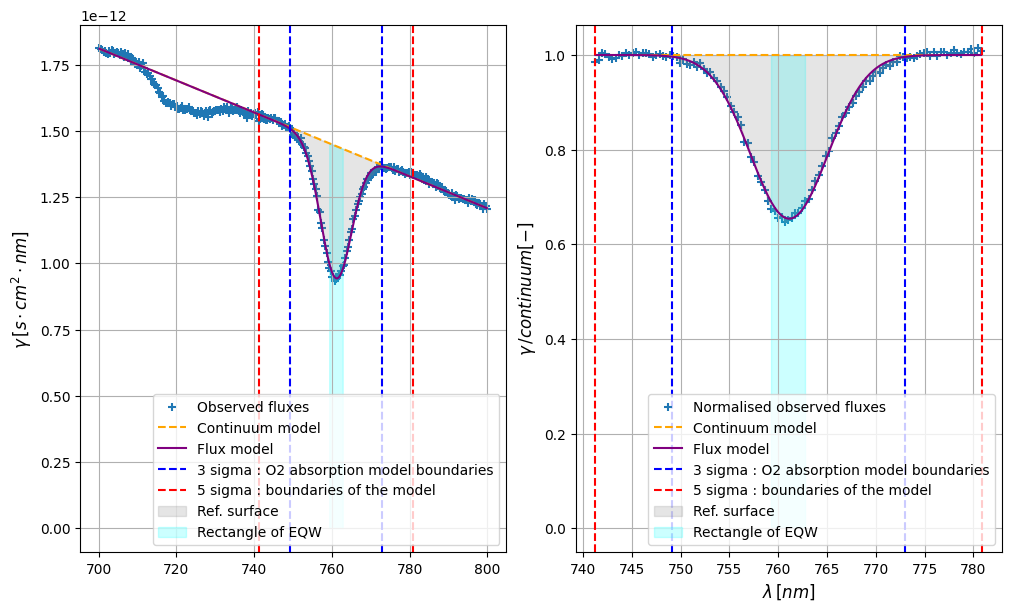

In [44]:
airmass = np.empty_like([])
pressure = np.empty_like([])
eqwidths = np.empty_like([])
eqw_errs = np.empty_like([])
loc=-1
for spec in spec_dict_good:
    #print(spec)
    loc += 1
    airmass_ = spec_dict_good[spec]['airmass']
    pressure_ = spec_dict_good[spec]['pressure']
    
    lambda_ = spec_dict_good[spec]['all_lambdas']
    flux_ = spec_dict_good[spec]['all_fluxes']
    flux_err_ = spec_dict_good[spec]['all_fluxes_err']
    #print(lambda_)
    #print(flux_)
    
    if loc%10 == 0 :
        eqw_, eqw_err_, mod, cov, xline, fline, xcontinuum, cont_at_line, area_l_, area_c_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=True, return_fit=True)
    else:
        eqw_, eqw_err_, mod, cov, xline, fline, xcontinuum, cont_at_line, area_l_, area_c_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=False, return_fit=True)

    '''
    if eqwdb_<0.:
        print(seqn)
        plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
        eqwdb_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    elif eqwdf_<0.:
        print(seqn)
        plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
        eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    
    plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
    eqw0_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    
    plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
    eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
    '''
    airmass = np.append(airmass, airmass_)
    pressure = np.append(pressure, pressure_)
    eqwidths = np.append(eqwidths, eqw_)
    eqw_errs = np.append(eqw_errs, eqw_err_)
#airmass = np.array(airmass)
#pressure = np.array(pressure)
if save_txt:
    data = np.transpose(np.array([airmass,pressure,eqwidth]))
    np.savetxt('eqw_data_{0}_{1}_{2}.txt'.format(obs_date,filter,disperser),data,header='airmass pressure eqw')

Text(0.5, 0.98, 'Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit')

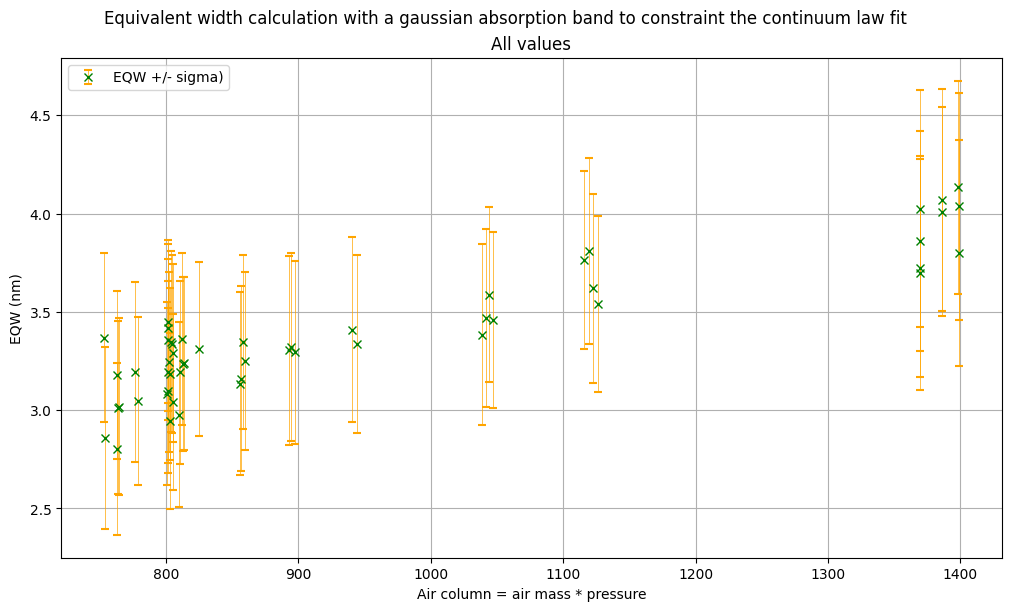

In [45]:
fig, axs = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)
#axs=axs.ravel()
#axs.scatter(airmass*pressure, eqwidth, label="test case")
axs.errorbar(airmass*pressure, eqwidths, yerr=eqw_errs, ls='', marker="x", color="green", ecolor="orange", elinewidth=.5, capsize=3, capthick=1.5, label="EQW +/- sigma)")
axs.grid()
axs.set_xlabel("Air column = air mass * pressure")
axs.set_ylabel("EQW (nm)")
axs.set_title("All values")
axs.legend()

#axs[1].scatter(airmass*pressure, eqwidths, label="test case")
#axs[1].set_ylim(2.7, 3.6)
#axs[1].grid()
#axs[1].set_xlabel("Air column = air mass * pressure")
#axs[1].set_ylabel("EQW (nm)")
#axs[1].set_title("Without obvious outliers")

fig.suptitle("Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit")

Text(0.5, 0.98, 'Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit')

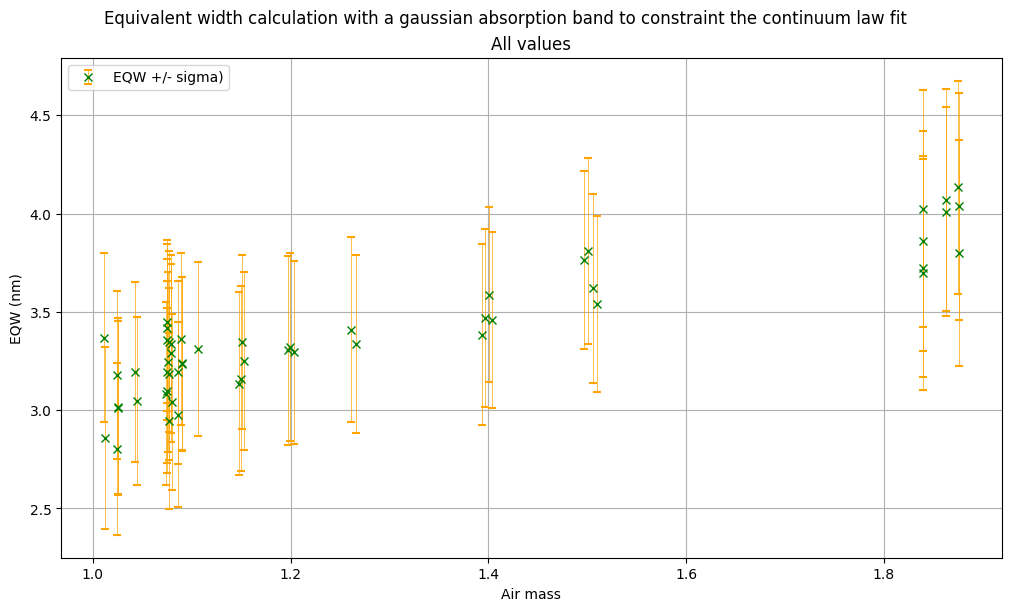

In [46]:
fig, axs = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)
#axs=axs.ravel()
#axs.scatter(airmass*pressure, eqwidth, label="test case")
axs.errorbar(airmass, eqwidths, yerr=eqw_errs, ls='', marker="x", color="green", ecolor="orange", elinewidth=.5, capsize=3, capthick=1.5, label="EQW +/- sigma)")
axs.grid()
axs.set_xlabel("Air mass")
axs.set_ylabel("EQW (nm)")
axs.set_title("All values")
axs.legend()

#axs[1].scatter(airmass*pressure, eqwidths, label="test case")
#axs[1].set_ylim(2.7, 3.6)
#axs[1].grid()
#axs[1].set_xlabel("Air column = air mass * pressure")
#axs[1].set_ylabel("EQW (nm)")
#axs[1].set_title("Without obvious outliers")

fig.suptitle("Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit")

# Now we condense the whole process and iterate on dates

Text(0.5, 0.98, 'Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit')

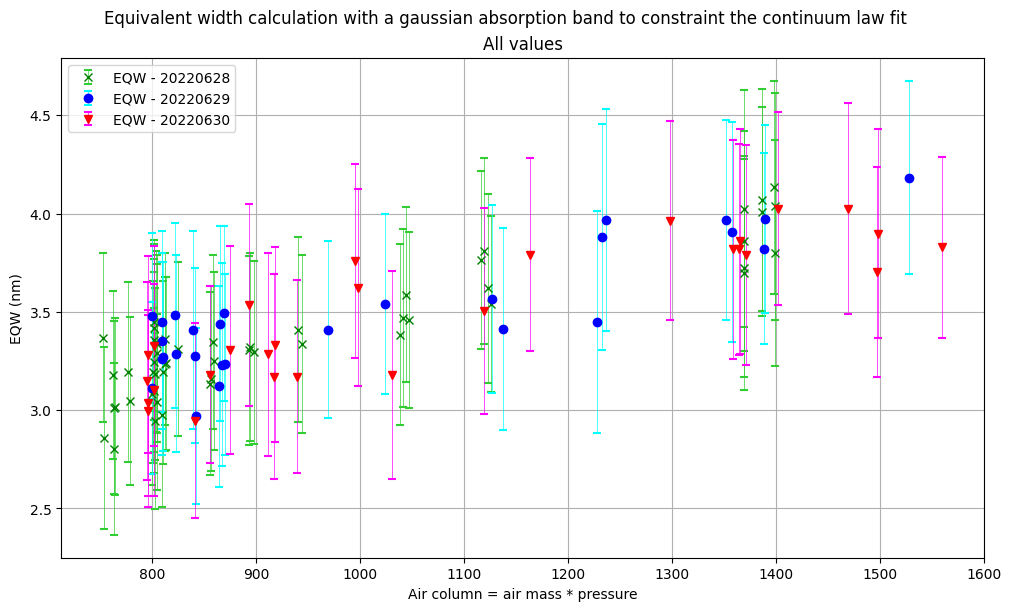

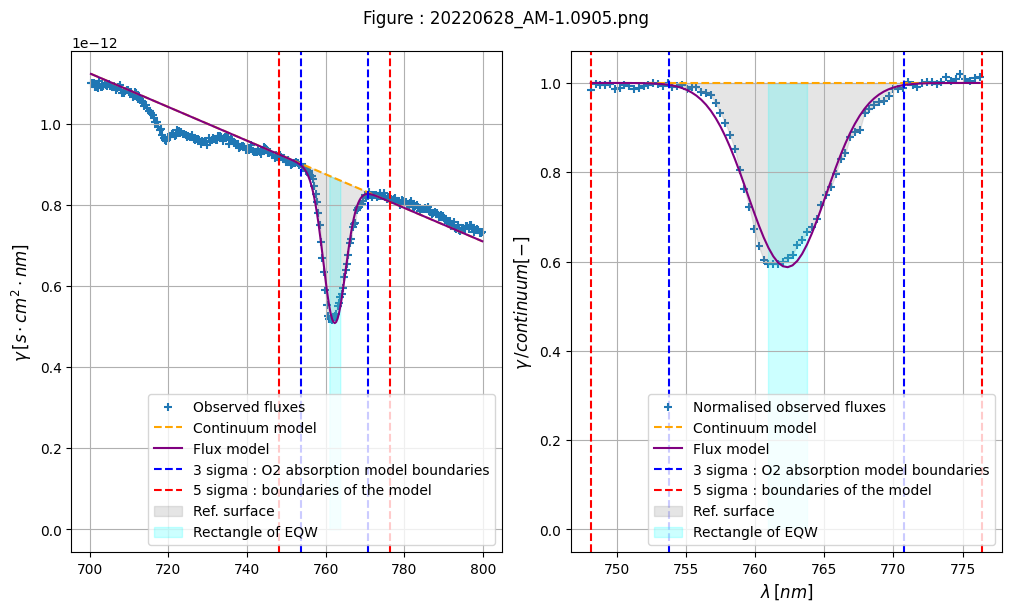

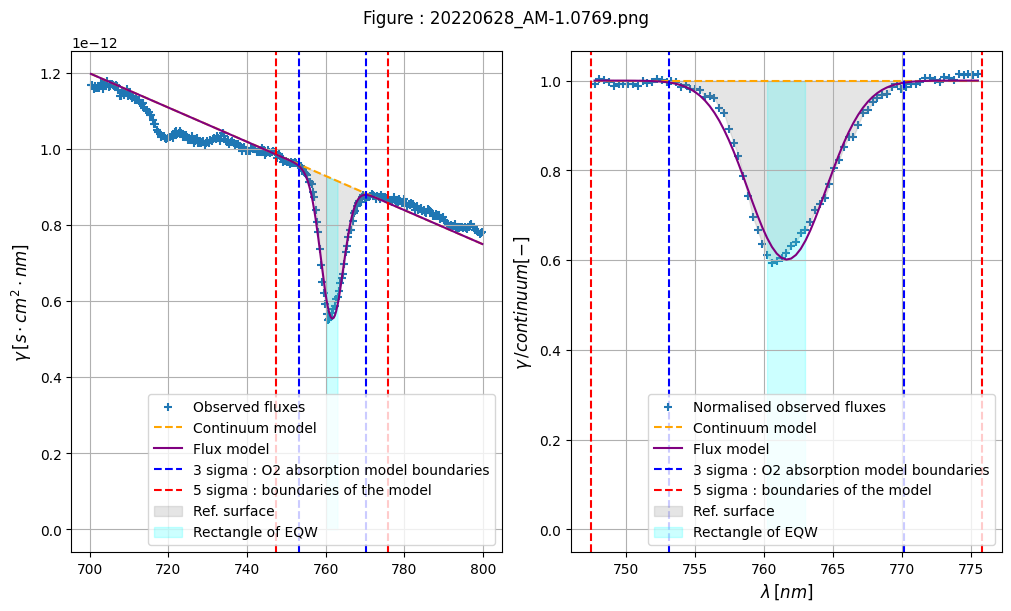

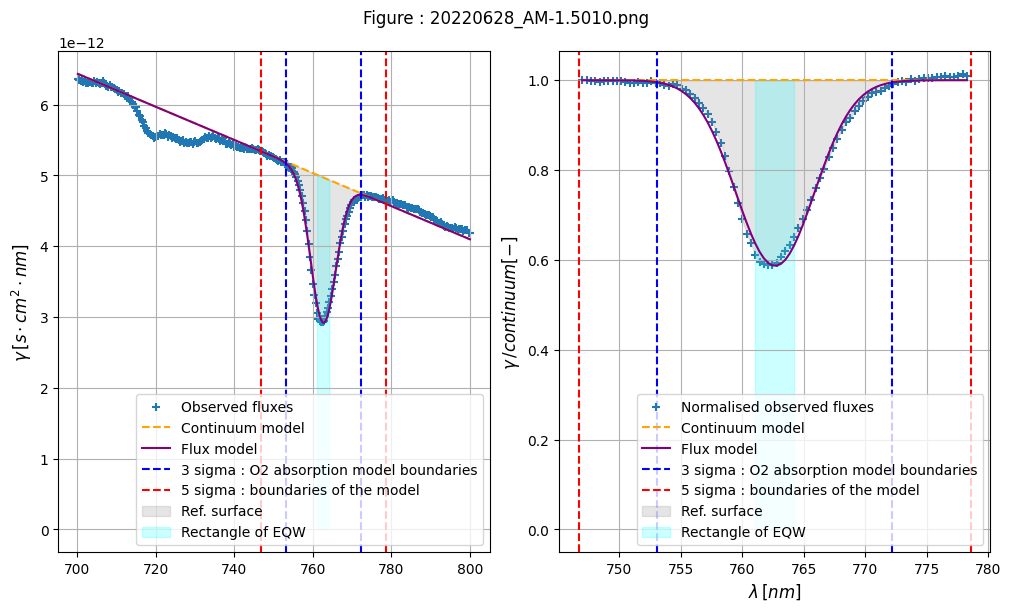

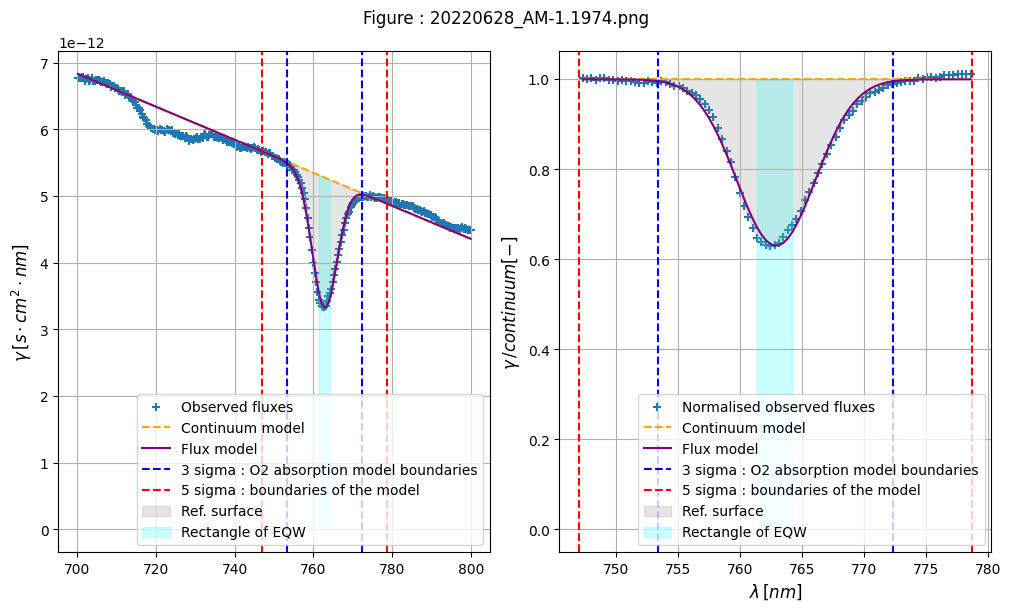

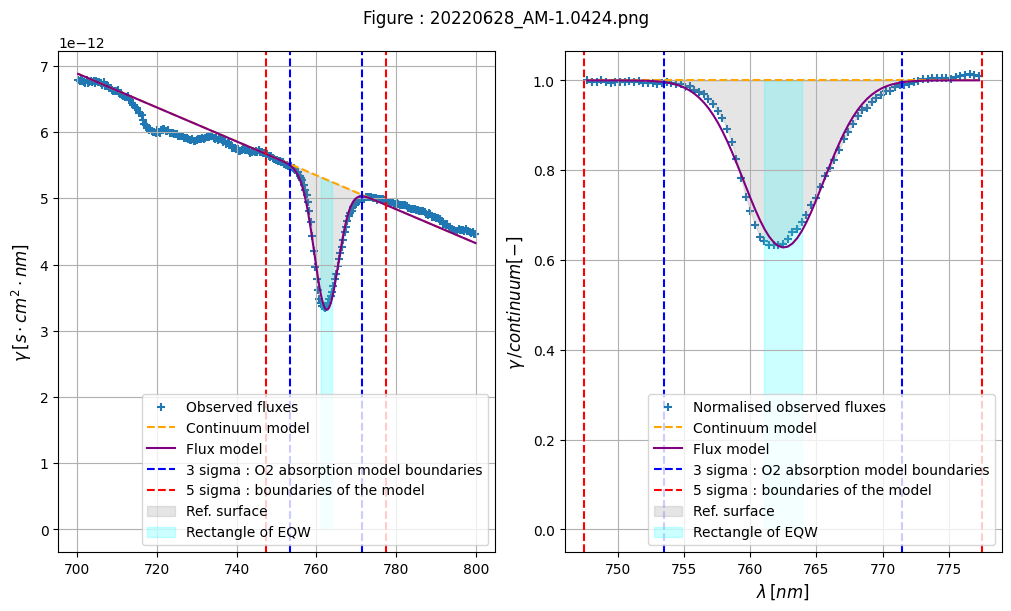

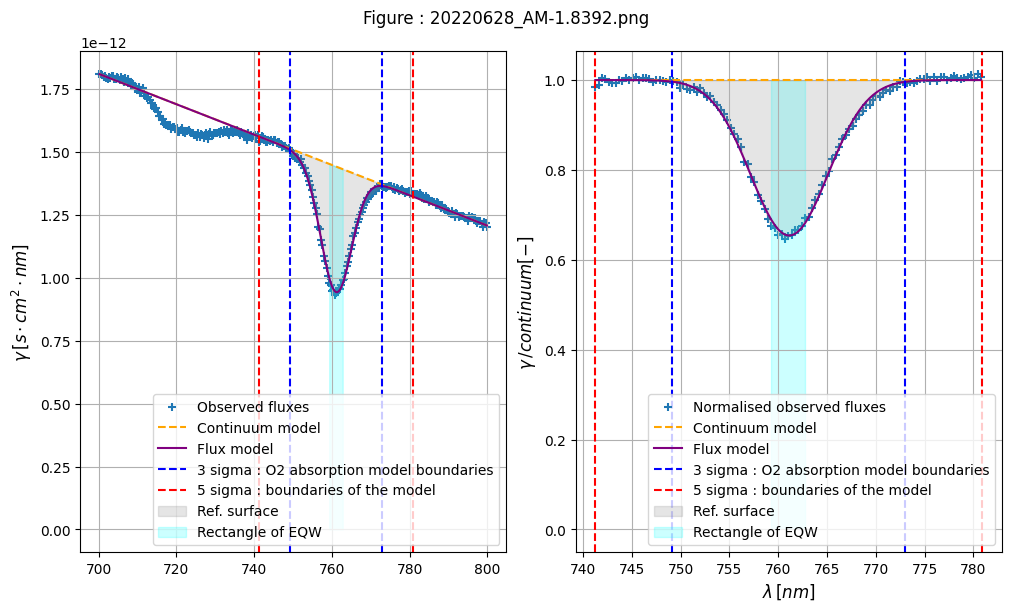

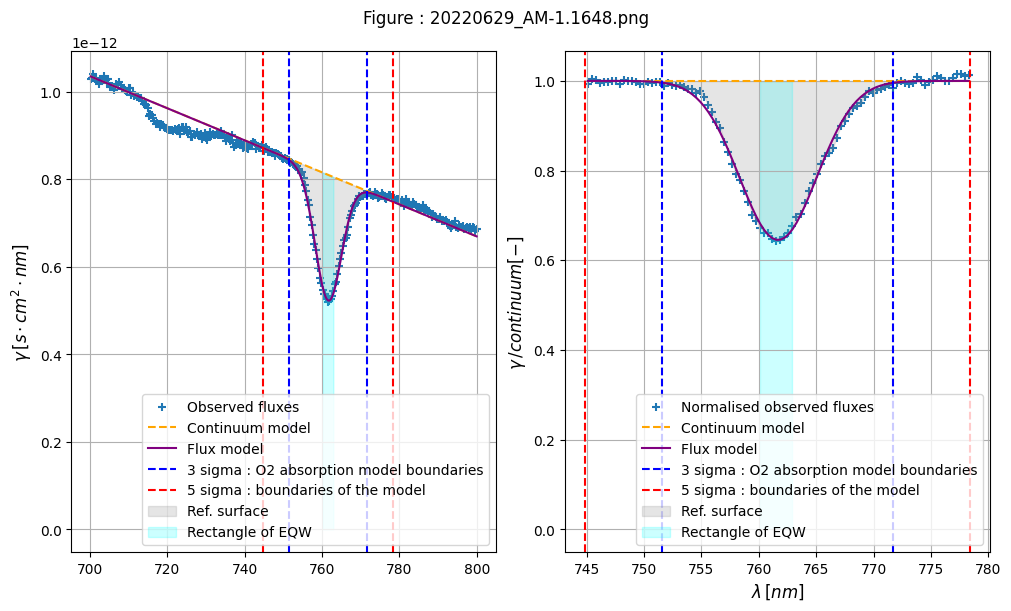

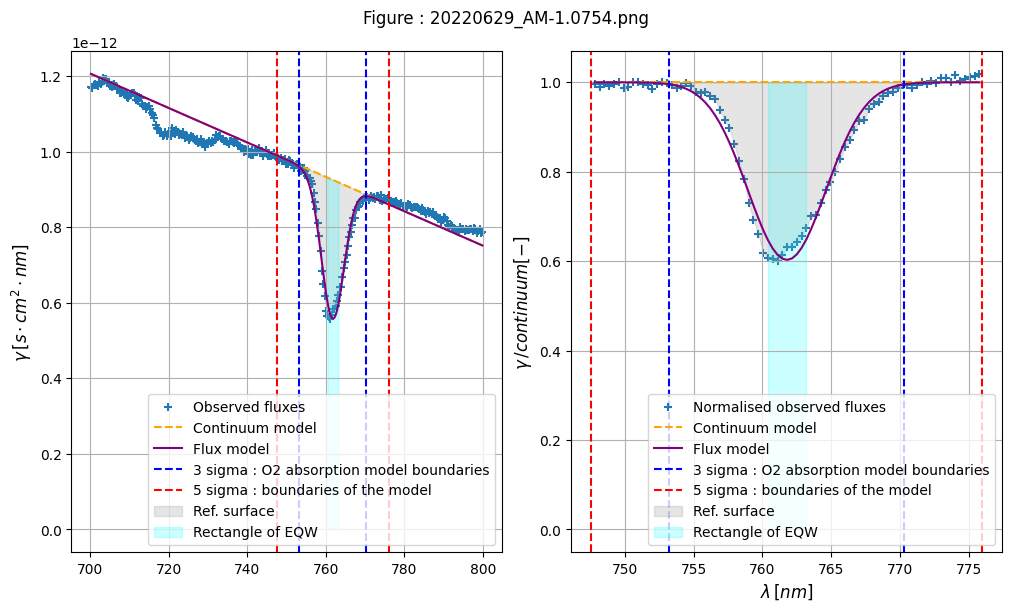

In [ ]:
############################################
## Initialise data and formatting options ##
##      May be improved or automated      ##
############################################
inputdir = '/pbs/throng/lsst/users/mrodrigu/desc/AuxTelComm/notebookccdm_gen3/bouguerlines/2022_09/data/'
file_label = 'run-auxtel-holo-{0}-{1}~{2}-config_DECONVOLUTION_PSF1D.pickle'
outdir = './output_files/'

bad_spec_dict = {'20220628':[171,223,250,251,400,425,479,480,538,593,654,655,656,657,683,708],
                 '20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593]}

if not os.path.exists(outdir):
    os.mkdir(outdir)

obs_dates = bad_spec_dict.keys() #np.array(['20220628', '20220629', '20220630'])
filter_ = 'FELH0600'
disperser = 'holo4_003'
save_txt = False

markerCols = ['green', 'blue', 'red']
errbarCols = ['limegreen', 'cyan', 'magenta']
markerStyle = ['x', 'o', 'v']

#####################################
## Main function definition, could ##
##    be done outside this block   ##
#####################################
def eqw_norm(x, flux, abs_min, abs_max, central_lambda=762., return_fit=False, make_plot=True, plot_name='test.png'): 
    
    def fun_fit(x, a, b, mu, sigma, k):
        o2abs = norm(loc=mu, scale=sigma)
        return (a*x + b)-k*o2abs.pdf(x)
    
    def continuum_error(l0, sigma_a, sigma_b):
        return np.sqrt( np.power(sigma_a*l0, 2.) + np.power(sigma_b, 2.) )

    def area_ul_error(flux_error, lambda_vec):
        delta_lambda = np.mean( np.diff(lambda_vec) )
        return np.sqrt( np.sum( np.power(flux_error, 2.) ) * np.power(delta_lambda, 2.) )

    def area_l_error(sigma_area_cont, sigma_area_ul):
        return np.sqrt( np.power(sigma_area_cont, 2.) + np.power(sigma_area_ul, 2.) )

    def eqw_error(cont_at_line, line_area, sigma_cont, sigma_area_line):
        sigma2_eqw = np.power(sigma_area_line / cont_at_line, 2.) + np.power(line_area*sigma_cont / np.power(cont_at_line, 2.), 2.)
        return np.sqrt(sigma2_eqw)
    
    mask_for_fit = (x >= abs_min) * (x <= abs_max)
    p1, cov = curve_fit(fun_fit, x[mask_for_fit], flux[mask_for_fit], p0=[1., 0.0, central_lambda, 2.0, 1.0])
    
    o2_band_centre = p1[2]
    min_cont, max_cont = o2_band_centre - 5*p1[3], o2_band_centre + 5*p1[3]
    
    xmask_continuum = (x >= min_cont) * (x <= max_cont)
    mod, cov = curve_fit(fun_fit, x[xmask_continuum], flux[xmask_continuum], p0=[p1[0], p1[1], p1[2], p1[3], p1[4]])
    
    def spec_mod(x):
        return fun_fit(x, mod[0], mod[1], mod[2], mod[3], mod[4])
    
    def continuum(x):
        return mod[0]*x+mod[1]

    o2_band_centre = mod[2]
    min_lin, max_lin = o2_band_centre - 3*mod[3], o2_band_centre + 3*mod[3]
    min_cont, max_cont = o2_band_centre - 5*mod[3], o2_band_centre + 5*mod[3]
    xmask_continuum = (x>=min_cont)*(x<=max_cont)
    
    xline0 = x[mask_for_fit]
    fline0 = flux[mask_for_fit]
    
    xline = x[xmask_continuum]
    fline = flux[xmask_continuum]
    xmask_line = (xline>=min_lin)*(xline<=max_lin)
    xline_model = xline[xmask_line]
    fline_model = spec_mod(xline_model)
    
    def normed_cont(x): ## must return 1.
        return continuum(x) / continuum(x)
    def normed_spec(x):
        return spec_mod(x) / continuum(x)
    
    norm_array = continuum(xline)
    
    area_c, area_c_err = quad(normed_cont, min_lin, max_lin)
    #area_ul = quad(normed_spec, min_lin, max_lin)[0]
    area_ul = np.trapz(fline[xmask_line]/norm_array[xmask_line], xline_model)
    #area_c = quad(normed_cont, min_cont, max_cont)[0]
    #area_ul = quad(normed_spec, min_cont, max_cont)[0]
    area_l = area_c-area_ul
    #print(area_c)
    #print(area_ul)
    #print(area_l)
    
    cont_min = continuum(o2_band_centre)
    eqw = area_l #/cont_min
    #print('EQW = ',eqw)
        
    sigma_a = np.sqrt(cov[0,0])
    sigma_b = np.sqrt(cov[1,1])
    delta_line = np.sqrt(cov[2,2])
    
    #print(cont_min)
    #print(area_l)
    #print(area_c_err)
    
    cont_err_ = continuum_error(central_lambda, sigma_a, sigma_b)
    #print(cont_err_)
    
    area_ul_err_ = area_ul_error(fline[xmask_line]/continuum(norm_array[xmask_line]), xline_model)
    #print(area_ul_err_)
    
    area_l_err_ = area_l_error(area_c_err, area_ul_err_)
    #print(area_l_err_)
    
    #eqw_err_ = eqw_error(cont_min, area_l_, cont_err_, area_l_err_)
    eqw_err_ = eqw_error(1., area_l, cont_err_, area_l_err_)
    #print(eqw_err_)
    
    #print('----------')
    
    eqwmask = (xline_model>=o2_band_centre-eqw/2.)*(xline_model<=o2_band_centre+eqw/2.)
    #print(continuum)
    #print(xmin_line-eqw/2.,xmin_line+eqw/2.)
    
    if make_plot:
        fig, axs=plt.subplots(1,2,figsize=(10,6), constrained_layout=True)
        axs=axs.ravel()
        axs[0].scatter(xline0, fline0, marker="+", label="Observed fluxes")
        axs[0].plot(xline0, continuum(xline0), ls='--', color='orange', label="Continuum model")
        axs[0].plot(xline0, spec_mod(xline0), ls='-', color='purple', label="Flux model")
        axs[0].axvline(x=min_lin,color='b',ls='--', label="3 sigma : O2 absorption model boundaries")
        axs[0].axvline(x=max_lin,color='b',ls='--')
        axs[0].axvline(x=min_cont,color='r',ls='--', label="5 sigma : boundaries of the model")
        axs[0].axvline(x=max_cont,color='r',ls='--')
        axs[0].fill_between(xline_model, continuum(xline_model), fline[xmask_line], color='gray',alpha=0.2, label="Ref. surface")
        #axs[0].fill_between(xline_model[eqwmask], continuum(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        #axs[0].fill_between(xline_model, continuum(xline_model), spec_mod(xline_model), color='gray',alpha=0.2, label="Ref. surface")
        axs[0].fill_between(xline_model[eqwmask], continuum(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        axs[1].set_xlabel(r'$\lambda \, [nm]$',fontsize=12)
        axs[0].set_ylabel(r'$\gamma \, [s \cdot cm^2 \cdot nm]$',fontsize=12)
        axs[0].grid()
        axs[0].legend(loc="lower right")
        
        
        axs[1].scatter(xline, fline/norm_array, marker="+", label="Normalised observed fluxes")
        axs[1].plot(xline, normed_cont(xline), ls='--', color='orange', label="Continuum model")
        axs[1].plot(xline, normed_spec(xline), ls='-', color='purple', label="Flux model")
        axs[1].axvline(x=min_lin,color='b',ls='--', label="3 sigma : O2 absorption model boundaries")
        axs[1].axvline(x=max_lin,color='b',ls='--')
        axs[1].axvline(x=min_cont,color='r',ls='--', label="5 sigma : boundaries of the model")
        axs[1].axvline(x=max_cont,color='r',ls='--')
        axs[1].fill_between(xline_model, normed_cont(xline_model), fline[xmask_line]/norm_array[xmask_line], color='gray',alpha=0.2, label="Ref. surface")
        #axs[1].fill_between(xline_model[eqwmask], normed_cont(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        #axs[1].fill_between(xline_model, normed_cont(xline_model), normed_spec(xline_model), color='gray',alpha=0.2, label="Ref. surface")
        axs[1].fill_between(xline_model[eqwmask], normed_cont(xline_model[eqwmask]), color='cyan', alpha=0.2, label="Rectangle of EQW")
        axs[1].set_xlabel(r'$\lambda \, [nm]$',fontsize=12)
        axs[1].set_ylabel(r'$\gamma \, / continuum [-]$',fontsize=12)
        axs[1].grid()
        axs[1].legend(loc="lower right")
        
        fig.suptitle("Figure : "+plot_name)
        '''
        plot_outdir = 'output_plots/eqw_line_fit_{0}/'.format(source_spec)
        if os.path.exists(plot_outdir)==False:
            os.mkdir(plot_outdir)
        plt.savefig(plot_outdir+plot_name) 
        '''
    if return_fit:
        return eqw, eqw_err_, mod, cov, xline, fline, continuum(xline), cont_min, area_l, area_c_err
    else:
        return eqw, eqw_err_

#########################################    
## Run everything and iterate on dates ##
#########################################
fig, axs = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)

for obs_date, mstyle, mcol, ecol in zip(obs_dates, markerStyle, markerCols, errbarCols):
    inputfile = os.path.join( inputdir, file_label.format(obs_date, filter_, disperser) )
    with open(inputfile,'rb') as f:
        spec_dict = pickle.load(f)
    
    bad_spec = bad_spec_dict[obs_date]

    spec_dict_good = {}
    for key in spec_dict.keys():
        if int(spec_dict[key]['number']) not in bad_spec:
            spec_dict_good[key] = spec_dict[key]

    #ref_obs = 'exposure_2022062800143_postisrccd_spectrum.fits'
    #lambda_ref = spec_dict_good[ref_obs]['all_lambdas']
    #flux_ref = spec_dict_good[ref_obs]['all_fluxes']
    
    
    airmass = np.empty_like([])
    pressure = np.empty_like([])
    eqwidths = np.empty_like([])
    eqw_errs = np.empty_like([])
    loc=-1
    for spec in spec_dict_good:
        loc += 1
        airmass_ = spec_dict_good[spec]['airmass']
        pressure_ = spec_dict_good[spec]['pressure']
        lambda_ = spec_dict_good[spec]['all_lambdas']
        flux_ = spec_dict_good[spec]['all_fluxes']
        flux_err_ = spec_dict_good[spec]['all_fluxes_err']

        if loc%10 == 0 :
            eqw_, eqw_err_, mod, cov, xline, fline, xcontinuum, cont_at_line, area_l_, area_c_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=True, return_fit=True, plot_name="{}_AM-{:.4f}.png".format(obs_date, airmass_))
        else:
            eqw_, eqw_err_, mod, cov, xline, fline, xcontinuum, cont_at_line, area_l_, area_c_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=False, return_fit=True)

        '''
        if eqwdb_<0.:
            print(seqn)
            plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
            eqwdb_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
        elif eqwdf_<0.:
            print(seqn)
            plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
            eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)

        plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
        eqw0_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)

        plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
        eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
        '''
        
        airmass = np.append(airmass, airmass_)
        pressure = np.append(pressure, pressure_)
        eqwidths = np.append(eqwidths, eqw_)
        eqw_errs = np.append(eqw_errs, eqw_err_)
    if save_txt:
        data = np.transpose(np.array([airmass,pressure,eqwidth]))
        np.savetxt('eqw_data_{0}_{1}_{2}.txt'.format(obs_date,filter_,disperser),data,header='airmass pressure eqw')

    axs.errorbar(airmass*pressure, eqwidths, yerr=eqw_errs, ls='', marker=mstyle, color=mcol, ecolor=ecol, elinewidth=.5, capsize=3, capthick=1.5, label="EQW - {}".format(obs_date))

###################
# format the plot #
###################
axs.grid()
axs.set_xlabel("Air column = air mass * pressure")
axs.set_ylabel("EQW (nm)")
axs.set_title("All values")
axs.legend()
fig.suptitle("Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit")